In [1]:
# data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as plx

%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# data manipulation
import numpy as np # linear algebra
import pandas as pd # data <processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from statsmodels.othermod.betareg import BetaModel

# config for packages
pd.options.display.max_columns = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


## Data Preprocessing
We have done several steps to ensure, that our data has a high quality in order for the models to perform well. Also we used accepted loans only, because our models are supervised only (so we need to know, if the loan got paid back or not).

For **data cleaning** we:
- removed features with more than 50% null values
- filtered categorical variables
- Encoded "bad" and "good" loans in a target variable (such that we can use binary classification models on it)
    - "bad" -> not paid ("charged off") or more than one month late
    - "good" else
- one hot encoded categorical variables

**Categorical information considered**:
- on employment of borrowers
- Homeownership of borrowers
- purpose
- verification of the borrowers source
- grade of the borrower

**Continuous information considered**:
- Distributions of:
    1. loan amount
    2. interest rate
    3. annual income
    4. debt to income ratio
    5. fico range over the course of the payment time (fico -> american SCHUFA)
    6. inqueries in the last 6 months (how much the bank has inquired the borrower in the last 6 months)
    7. Revolving ballance (how much is there to pay for the rest of the month for the borrower)

**Outlier removal**
- In some cases we used interquantile ranges to determine outliers like so:
$$
\text{Lower lim} = Q_1- 1.5IQR \\
\text{Higher lim} = Q_3 + 1.5 IQR
$$

**Exploratory analysis**
- Correlation heatmap
    - removed features with very high correlation (because it might lead to problems in the logistic regression)
- Correlation with dependent variable
    - Looking into influence on the the `good_bad` variable
    - This will help us with feature selection
    
Train-test-split
- We did a train-test split from `sklearn` to benchmark the models

Finally we exported the clean data into a seperate Kaggle Dataset card, such that we can collaborate on it.

In [2]:
loan_data = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz')

loan_data.head()

/tmp/ipykernel_1099/2424937207.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [3]:
len(loan_data)

2260701

Over 2 million rows

### removing features with more than 10% null values
We didn't want to augment the data too much, because the models might be too much influenced by our filling tactics

In [4]:
def remove_null_variables(data,t):
    ''' This function removes the columns that has less or equal 90% of the observations'''
    data = data.loc[:,(loan_data.isnull().sum()/len(loan_data) <= t).values] 
    return data

In [5]:
loan_data = remove_null_variables(loan_data,0.1)

In [6]:
# print the 30 features with the highest null value proportion
(loan_data.isnull().sum()/len(loan_data)).sort_values(ascending = False).head(30)

emp_title                     0.073872
num_tl_120dpd_2m              0.067983
emp_length                    0.064998
mo_sin_old_il_acct            0.061531
bc_util                       0.033664
percent_bc_gt_75              0.033358
bc_open_to_buy                0.033161
mths_since_recent_bc          0.032488
pct_tl_nvr_dlq                0.031169
avg_cur_bal                   0.031131
num_rev_accts                 0.031101
mo_sin_old_rev_tl_op          0.031101
mo_sin_rcnt_rev_tl_op         0.031101
num_accts_ever_120_pd         0.031101
num_actv_bc_tl                0.031101
num_actv_rev_tl               0.031101
num_bc_tl                     0.031101
num_il_tl                     0.031101
num_op_rev_tl                 0.031101
num_rev_tl_bal_gt_0           0.031101
total_il_high_credit_limit    0.031101
total_rev_hi_lim              0.031101
mo_sin_rcnt_tl                0.031101
tot_cur_bal                   0.031101
tot_coll_amt                  0.031101
num_tl_30dpd             

## Categorical features
Starting to work through categorical features. Our main goal to use categorical features as dummy variables. In this part we assess weither we can use the feature as one-hot-encoded or not.

In [7]:
categorical_variables = loan_data.dtypes[loan_data.dtypes == 'object'].index.to_list()
loan_data.loc[:,categorical_variables].head()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,66310712,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,68476807,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


In [8]:
loan_data.loc[ loan_data.isnull().loan_status, :].head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528961,Total amount funded in policy code 1: 1741781700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528962,Total amount funded in policy code 2: 564202131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651664,Total amount funded in policy code 1: 1791201400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The loans that didn't get any loan information are not of use. We can remove these columns.

In [9]:
loan_data = loan_data.loc[~ loan_data.isnull().loan_status, :]

### Creating the dependent variable
Again we want to model the $EL$ equation:
$$
EL = P(X = \text{default}) \mathbb E(Loss|X = \text{default})
$$
And therefore model $P(X=\text{default})$ and $\mathbb E(Loss|X = \text{default})$ separately. To model the first, we need a binary variable.

In a way, this is a device for differnciating good and bad loans. It may happen, that we get the money for the loan, but just very late. This would still be a bad loan. Therefore we will classify late payments (more than one month) also as "bad" or "default".

In [10]:
loan_data.loc[:,'good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

### Home ownership and employment: Exploratory analysis and transformatoin
Now we take into account the borrowers jobs, length of employment and home ownership.

In [11]:
# we changed `emp_title` to upper case in order that there are no repeated values
loan_data['emp_title'] = loan_data['emp_title'].str.upper()
# checking if the transformation worked
loan_data['emp_title'].head()

0                        LEADMAN
1                       ENGINEER
2                   TRUCK DRIVER
3    INFORMATION SYSTEMS OFFICER
4            CONTRACT SPECIALIST
Name: emp_title, dtype: object

In [12]:
loan_data['emp_title'].value_counts()

emp_title
TEACHER                       46125
MANAGER                       42822
OWNER                         31740
REGISTERED NURSE              21407
DRIVER                        20786
                              ...  
RESIDENTIAL NURSE MANAGER         1
SPECIAL AGENT SUPERVISOR          1
RELAY TECHNICIAN PRINCIPAL        1
FNS SUPERVISOR                    1
EXEC DIR INTERNAL AUDIT           1
Name: count, Length: 438350, dtype: int64

Most borrowers are teachers or managers. Might be a good indicator to look further into it.

In [13]:
print( "Num of job descriptions: "+str(len(loan_data['emp_title'].value_counts().index)))

Num of job descriptions: 438350


We have over half a million job descriptions. It therefore doesn't make sense to create a dummy variable. we would need to aggregate job descriptions.

---

Now we check `emp_length`, which is the employer length of working.
For a banking perspective this variable is really important since we know the satability of the employee.

For this we need to:
- fix `null` values, by assuming the borrower has no experience, if no value was provided
- convert it to a integer feature


In [14]:
loan_data['emp_length'].value_counts(dropna= False)

emp_length
10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
NaN          146907
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: count, dtype: int64

In [15]:
# transfering to another variable
loan_data['emp_length_num'] = loan_data['emp_length'].str.extract('(\d+)')

Together with the employment-length we are also filling:
 1. home ownership
 2. purpose
 3. term (time of the credit) Most of the observations are up to 36 months so we assume 36 months
 4. grade: also most of the loans got B, so we take B
 5. verfication status of income -> no value given -> no credibility
---

The variables `verification_status`	`issue_d`,`pymnt_plan`,`url`, `title` are not of our interest, since they do not support any meaningfull insight to our model.

In [16]:
loan_data.fillna({'emp_length_num': 0, # assuming zero years of experience
                   'home_ownership': 'OTHER',
                   'purpose': 'other',
                    'term': loan_data.term.mode()[0], # set to the mode
                    'grade': loan_data.grade.mode()[0], # set to mode
                    'verification_status': 'Not Verified', # no information given -> no credibility
                   },inplace = True )

In [17]:
# typecast to int
loan_data = loan_data.astype({'emp_length_num': int})

Further we aggregate the feature `purpose` to not end up with too many dummies.

In [18]:
# also saving it in util variable
loan_data['purpose_trfrm'] = np.where(loan_data['purpose'] == 'debt_consolidation','debt_consolidation',
                                       np.where(loan_data['purpose'] == 'credit_card','credit_card',
                                               np.where(loan_data['purpose'] == 'home_improvement','home_improvement','other')))

In [19]:
loan_data['purpose_trfrm'].value_counts()

purpose_trfrm
debt_consolidation    1277877
credit_card            516971
other                  315363
home_improvement       150457
Name: count, dtype: int64

In [20]:
loan_data['home_ownership_orig'] = loan_data['home_ownership']
loan_data['purpose_trfrm_orig'] = loan_data['purpose_trfrm']
loan_data['grade_orig'] = loan_data['grade']
loan_data['term_orig'] = loan_data['term']

In [21]:
## we will save the categorical variables in a list in order to use it later
list_categorical = ['home_ownership','purpose_trfrm','grade', 'term']

loan_data = pd.get_dummies(loan_data,
                           columns = list_categorical,
                           prefix_sep=":",
                           drop_first = True,
                           dtype = int)

## Continous features
For the continuous variables we not only need to take into account the values but the distrubution themselves. Again we:
- filled `null` values
- remove outliers
- transform the features to be more normally distributed

In [22]:
# we get a look of all the variables that are continous and numeric
loan_data.loc[:,~loan_data.columns.isin(categorical_variables)].head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,good_bad,emp_length_num,home_ownership_orig,purpose_trfrm_orig,grade_orig,term_orig,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose_trfrm:debt_consolidation,purpose_trfrm:home_improvement,purpose_trfrm:other,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,term: 60 months
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,1.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,1,10,MORTGAGE,debt_consolidation,C,36 months,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,1.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,1,10,MORTGAGE,other,C,36 months,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,1.0,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,1,10,MORTGAGE,home_improvement,B,60 months,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,1.0,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,1,10,MORTGAGE,debt_consolidation,C,60 months,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,1.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,1,3,MORTGAGE,other,F,60 months,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [23]:
# creating some utility function

def inter_quartile_transform(col: pd.Series):
    values = col
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    # we use 1.5 as a used constant to dicern outliers
    lower_lim = Q1 - IQR*1.5 
    upper_lim = Q3 + IQR*1.5
    values[values <= lower_lim] = lower_lim
    values[values >= upper_lim] = upper_lim
    return values, lower_lim, upper_lim

In [24]:
# replacing null values with mean values
mean_cols = ['total_acc','loan_amnt', 'annual_inc', 'int_rate', 'dti', "tot_cur_bal", "revol_bal"]
mean_vals = loan_data.loc[:, mean_cols].mean()

loan_data.fillna(mean_vals, inplace = True)


### looking into distributions

<BarContainer object of 25 artists>

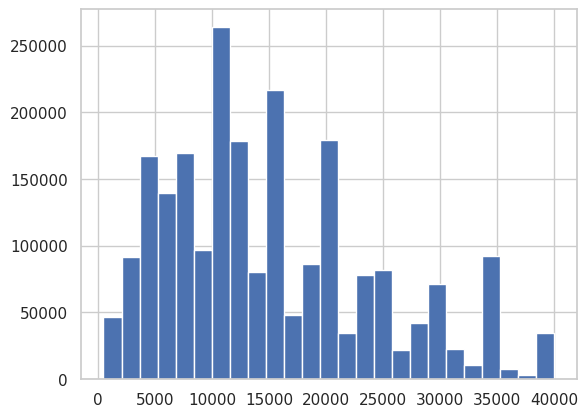

In [25]:
bins, counts, plot = plt.hist(loan_data.loan_amnt, bins = 25)
plot

We can see that the data is skewed to the right as expected, because we consider private households, that could not get a loan at the bank.

Peer-to-peer loans stay relatively low.

<BarContainer object of 25 artists>

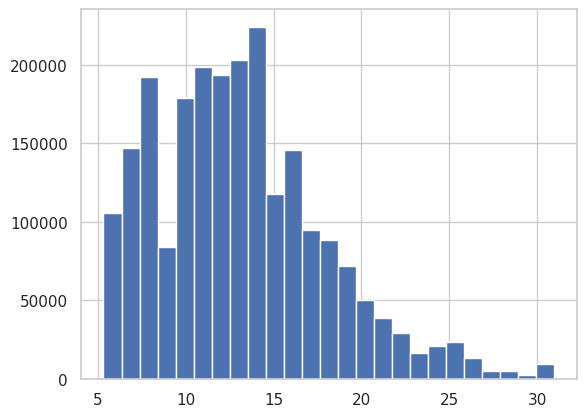

In [26]:
## now we will see the interest rate  
bins, count, plot = plt.hist(loan_data.int_rate, bins = 25)
plot

We can see, that the data is skewed to the right as expected, because it is less attractive to have a higher interest rate

<BarContainer object of 25 artists>

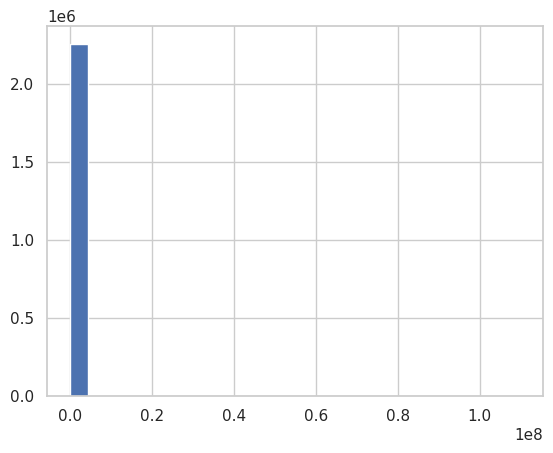

In [27]:
bins, count, plot = plt.hist(loan_data.annual_inc, bins = 25)
plot

We can see by the graph that there is a problem, possibly atypical values. We will need to set these outliers to the upper boundary of the whisker.

In [28]:
## To handle this situation we will use the interquartile range
loan_data["annual_inc_trfrm"], lower_lim, upper_lim  = inter_quartile_transform(loan_data["annual_inc"].copy())

<BarContainer object of 10 artists>

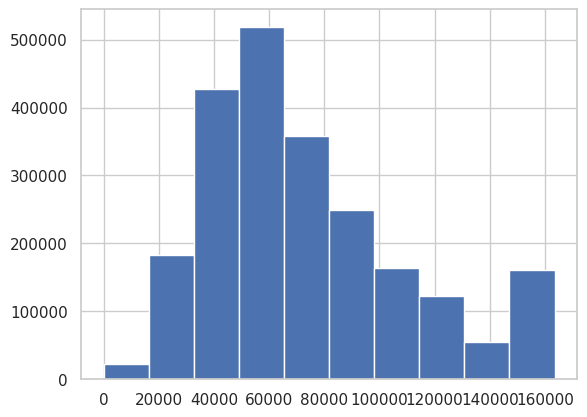

In [29]:
bins, count, plot = plt.hist(loan_data.annual_inc_trfrm)
plot

We see the tranformation worked, however 120k values were truncated. Maybe log-scale could be an alternative.

<BarContainer object of 25 artists>

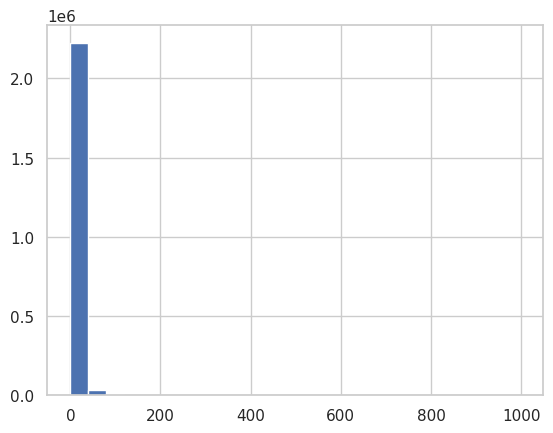

In [30]:
# now we plot the debt to income ratio
bins, count, plot = plt.hist(loan_data.dti, bins = 25)
plot

As we can see the distribution also suffers from outliers. We are also going to apply the interquartile transformation.

In [31]:
loan_data['dti_trfrm'], l_lim, u_lim = inter_quartile_transform(loan_data["dti"].copy())

<BarContainer object of 25 artists>

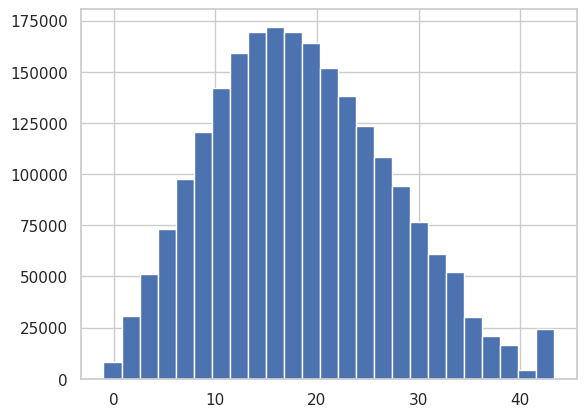

In [32]:
# ..and plot the distribution again
bins, count, plot = plt.hist(loan_data.dti_trfrm, bins = 25)
plot

<BarContainer object of 25 artists>

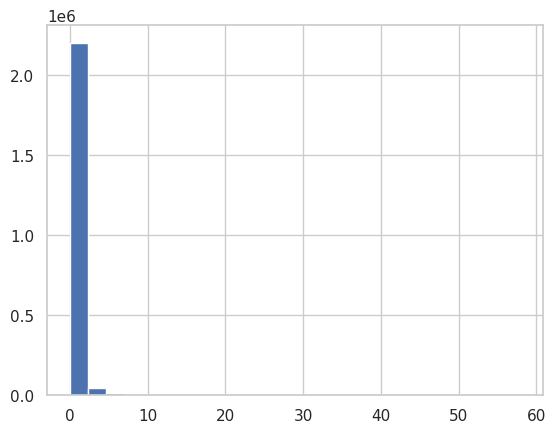

In [33]:
# now we plot the delinquency in the past 2 years
loan_data.fillna({"delinq_2yrs": 0}, inplace = True)

bins, count, plot = plt.hist(loan_data.delinq_2yrs, bins = 25)
plot
# we can see by the graph that there is a problem, possibly atypical values

In [34]:
loan_data['delinq_2yrs'].value_counts()/len(loan_data)

delinq_2yrs
0.0     8.135370e-01
1.0     1.244557e-01
2.0     3.595796e-02
3.0     1.306782e-02
4.0     5.829693e-03
5.0     2.919049e-03
6.0     1.644204e-03
7.0     9.121198e-04
8.0     5.409905e-04
9.0     3.618400e-04
10.0    2.459450e-04
11.0    1.605720e-04
12.0    1.163373e-04
13.0    7.298728e-05
14.0    5.308166e-05
15.0    3.848420e-05
16.0    2.432909e-05
18.0    1.327041e-05
17.0    1.327041e-05
19.0    1.017398e-05
20.0    7.519901e-06
21.0    5.308166e-06
22.0    2.211736e-06
24.0    1.769389e-06
26.0    1.327041e-06
30.0    8.846943e-07
25.0    8.846943e-07
23.0    8.846943e-07
29.0    8.846943e-07
27.0    4.423471e-07
39.0    4.423471e-07
28.0    4.423471e-07
32.0    4.423471e-07
58.0    4.423471e-07
35.0    4.423471e-07
42.0    4.423471e-07
36.0    4.423471e-07
Name: count, dtype: float64

For this type of data we will make a simpler rule:

If the delinquency after 2 years is above or equal to 10, we will put the maximum value as 10

In [35]:
loan_data['delinq_2yrs_trfrm'] = np.where(loan_data['delinq_2yrs']>= 10,10,loan_data['delinq_2yrs'])

Now we plot the graph again:

In [36]:
## now we plot the graph again
loan_data.fillna({"delinq_2yrs_trfrm": loan_data["delinq_2yrs_trfrm"].copy().mean()},
                  inplace = True)

<BarContainer object of 25 artists>

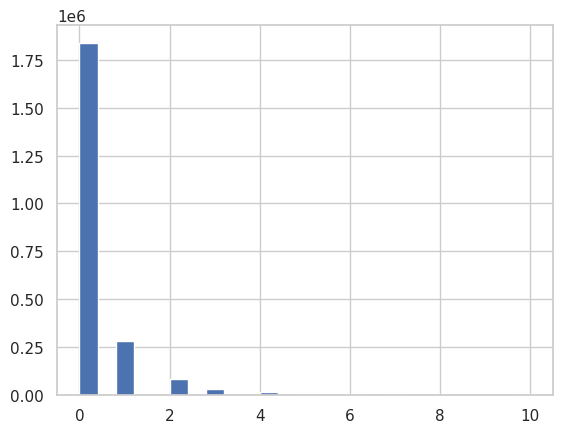

In [37]:
bins, count, plot = plt.hist(loan_data.delinq_2yrs_trfrm, bins = 25)
plot

In [38]:
# Now we fill the fico variables with the means
fico_features = ["fico_range_low", "fico_range_high", "last_fico_range_low", "last_fico_range_high"]
fico_means = loan_data.loc[:, fico_features].mean()
loan_data.fillna(fico_means, inplace = True)

<BarContainer object of 25 artists>

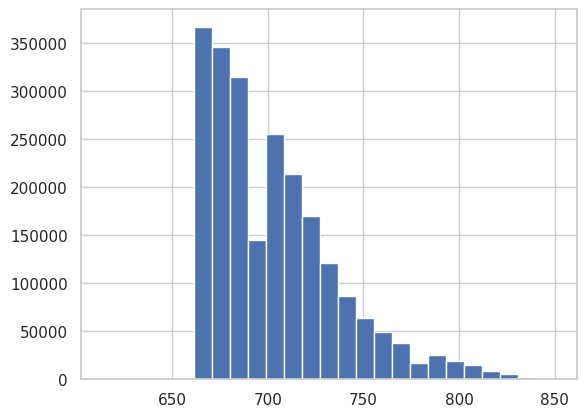

In [39]:
## playing around with the distributions
bins, count, plot = plt.hist(loan_data.fico_range_high, bins = 25)
plot 

In [40]:
loan_data['inq_last_6mths'].head()

0    1.0
1    4.0
2    0.0
3    0.0
4    3.0
Name: inq_last_6mths, dtype: float64

In [41]:
# Assuming if there was no value, that there were no inquiries
loan_data.fillna({"inq_last_6mths": 0},
                inplace = True)

<BarContainer object of 36 artists>

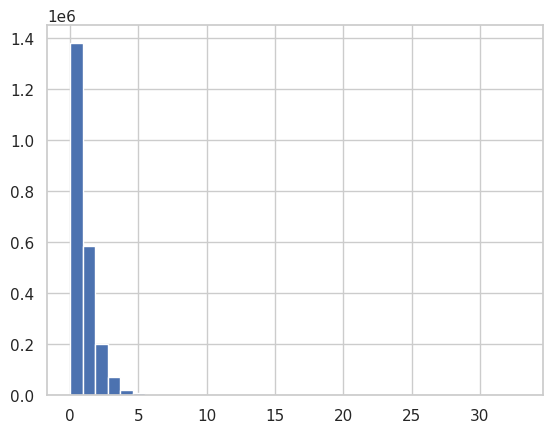

In [42]:
bins, count, plot = plt.hist(loan_data.inq_last_6mths, bins = 36)
plot

The graph that there is a problem, possibly outliers
But since is a numeric vector that indicates how many times the borrower was inquired in the banking system, it does not make sense to transform, since it is really possible, that the borrowes that have been inquired.
Have a bad behavior in other banks as well, maybe a pivot table can represent this in a better way.

In [43]:
inquery_6m_table = pd.crosstab(loan_data['inq_last_6mths'],loan_data['good_bad'])
inquery_6m_table['sum'] = inquery_6m_table[0] + inquery_6m_table[1]
inquery_6m_table['prop_good'] = inquery_6m_table[1]/inquery_6m_table['sum']
inquery_6m_table['prop_bad'] = inquery_6m_table[0]/inquery_6m_table['sum']
inquery_6m_table

good_bad,0,1,sum,prop_good,prop_bad
inq_last_6mths,,,,,
0.0,150464,1231288,1381752,0.891106,0.108894
1.0,84671,499719,584390,0.855112,0.144888
2.0,35054,165158,200212,0.824916,0.175084
3.0,14369,54640,69009,0.791781,0.208219
4.0,4223,13157,17380,0.757020,0.242980
5.0,1565,4667,6232,0.748877,0.251123
6.0,318,913,1231,0.741673,0.258327
7.0,68,127,195,0.651282,0.348718
8.0,46,76,122,0.622951,0.377049


In total, this feature does indicate, wheither we have a bad or good loan.

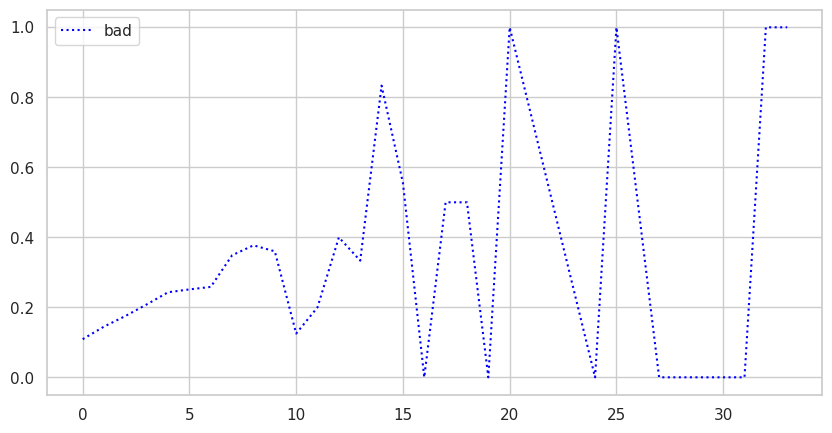

In [44]:
fig = plt.figure(figsize = (10, 5))
plt.plot(inquery_6m_table.index,inquery_6m_table['prop_bad'], linestyle = 'dotted',color = 'blue',label='bad')
# plt.plot(inquery_6m_table.index,inquery_6m_table['prop_good'], linestyle = 'dotted',color = 'red',label='good')
plt.legend(loc="upper left")
plt.show()
# We see at the beggining that as the number of inqueries increases at 14 inqueries for the bad clients,
# the more you reasearch a client in the financial system the proportion of bad clients increases.
# but after that the relationship breaks, because of few observations.
# This variable can be transformed into a categorical data for a better understanding

After 9 the support of our data is very low, that is why we need to aggragate this feature

In [45]:
# We now create a dummy variable from our graphed data
loan_data['inq_last_6mths:0'] = np.where((loan_data['inq_last_6mths'] == 0), 1, 0)
loan_data['inq_last_6mths:1-8'] = np.where((loan_data['inq_last_6mths'] >= 1) & (loan_data['delinq_2yrs'] <= 8), 1, 0)

In [46]:
# We now see open acc that is the number of open credits in the borrower credit life
loan_data.fillna({"open_acc": 0,
                 "pub_rec": 0,
                 }, inplace = True)

<BarContainer object of 25 artists>

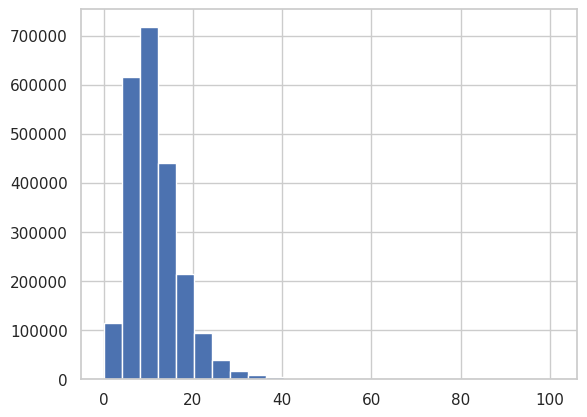

In [47]:
bins, count, plot = plt.hist(loan_data.open_acc, bins = 25)
plot

The data is skewed to the right, meaning that there are few clients that had a lot of credits compared to the average client.

<BarContainer object of 25 artists>

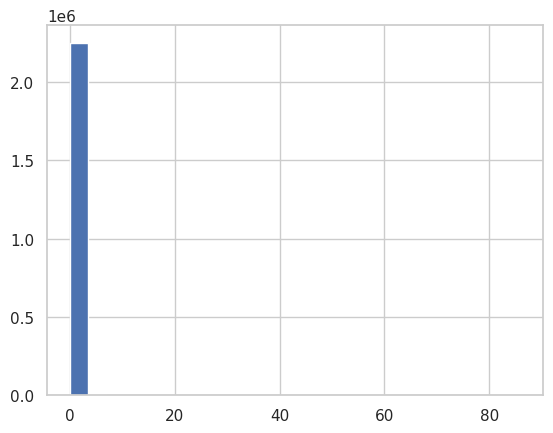

In [48]:
# Now we see the variable pub_rec, which is the number of derogatory records, that is
# negative information such as bankruptcies and liens
bins, count, plot = plt.hist(loan_data.pub_rec, bins = 25)
plot

In [49]:
loan_data['pub_rec'].value_counts()

pub_rec
0.0     1902787
1.0      305390
2.0       34154
3.0       10567
4.0        3872
5.0        1843
6.0         933
7.0         427
8.0         243
9.0         143
10.0         91
11.0         58
12.0         35
13.0         30
14.0         12
15.0         11
16.0         11
19.0          9
21.0          6
18.0          6
17.0          5
28.0          4
24.0          4
22.0          3
20.0          3
23.0          2
49.0          2
61.0          2
86.0          1
37.0          1
45.0          1
54.0          1
34.0          1
63.0          1
40.0          1
44.0          1
46.0          1
47.0          1
31.0          1
32.0          1
52.0          1
26.0          1
25.0          1
Name: count, dtype: int64

In [50]:
# We're going to aggregate, because the support becomes very small after 9
loan_data['pub_rec:0'] = np.where((loan_data['pub_rec'] == 0), 1, 0)
loan_data['pub_rec:1-9'] = np.where((loan_data['pub_rec'] >= 1) & (loan_data['delinq_2yrs'] <= 9), 1, 0)

<BarContainer object of 25 artists>

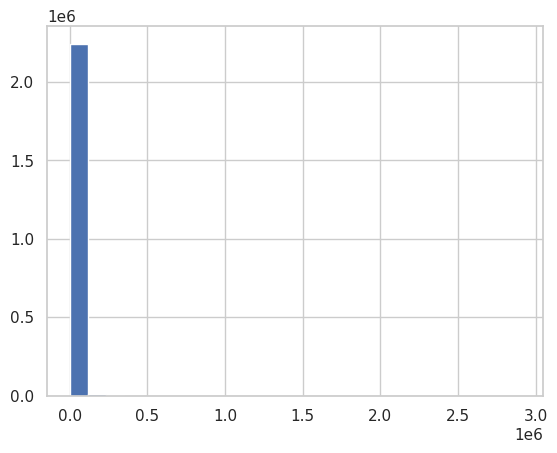

In [51]:
# Now we see the variable revol_bal, which is the revolving balance of the client, or more easy, the amount of the line 
# of credit that the client has to still pay for the next month for a revolving credit
bins, count, plot = plt.hist(loan_data.revol_bal, bins = 25)
plot

In [52]:
## To handle this situation we will use the interquartile range
print("mean of revol bal: %d \n median of revol bal: %d" % (loan_data.revol_bal.mean(), loan_data.revol_bal.quantile(0.5)))

mean of revol bal: 16658 
 median of revol bal: 11324


In [53]:
#Since our data is clearly skewed to the right, we will use this the upper-limit as the maximum for values that are above it
loan_data["revol_bal_trfrm"], l_l, u_l = inter_quartile_transform(loan_data.revol_bal.copy()) 

<BarContainer object of 25 artists>

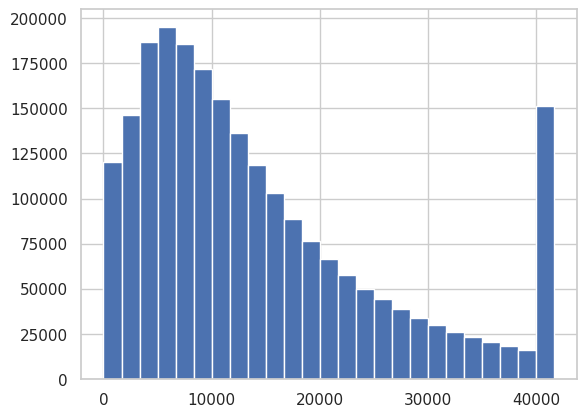

In [54]:
bins, count, plot = plt.hist(loan_data.revol_bal_trfrm, bins = 25)
plot

In [55]:
# Now we see the variable revol_until, which is the revolving balance of the client ratio, between, how much the the client
# uses the line of credit relative to the all available credir
loan_data.fillna({"revol_util": loan_data.revol_util.copy().mean()}, inplace= True)

<BarContainer object of 25 artists>

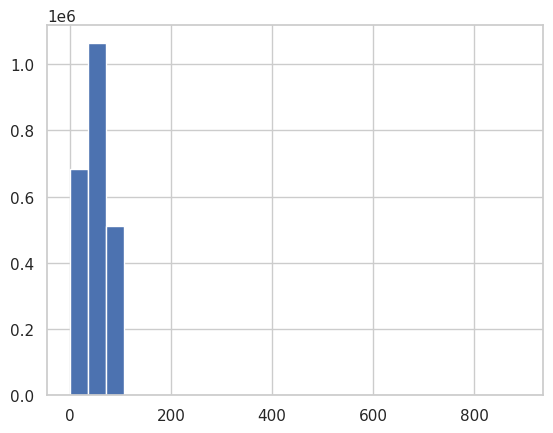

In [56]:
bins, count, plot = plt.hist(loan_data.revol_util, bins = 25)
plot

In [57]:
# Since there are clients that use more than they are allowed and our data distribution is not clearly represented
# we will make a transformarion with the IQR method
## To handle this situation we will use the interquartile range
loan_data["revol_util_trfrm"], l_l, u_l = inter_quartile_transform(loan_data.revol_util.copy())

<BarContainer object of 25 artists>

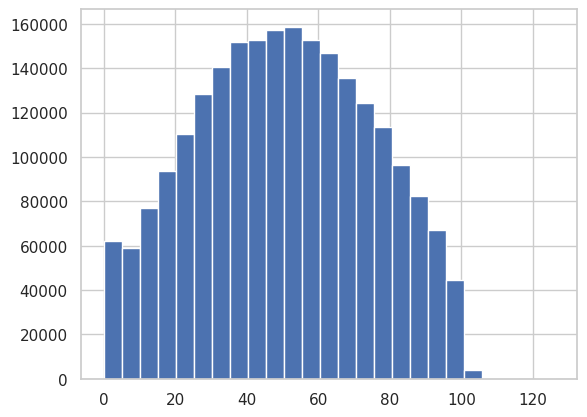

In [58]:
bins, count, plot = plt.hist(loan_data.revol_util_trfrm, bins = 25)
plot

### the variables are not part of the transformation since this reflects the actual client payments and bank collection
- out_prncp
- out_prncp_inv
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_amnt

In [59]:
loan_data['total_pymnt'].isnull().sum()

0

In [60]:
loan_data['collections_12_mths_ex_med'].describe()

count    2.260523e+06
mean     1.814580e-02
std      1.508131e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: collections_12_mths_ex_med, dtype: float64

In [61]:
# We now see collections_12_mths_ex_med Number of collections in 12 months excluding medical collections
loan_data.fillna({"collections_12_mths_ex_med": 0}, inplace = True)

<BarContainer object of 25 artists>

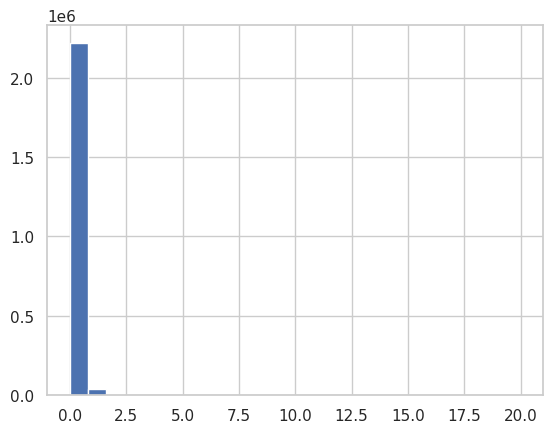

In [62]:
bins, count, plot = plt.hist(loan_data.collections_12_mths_ex_med, bins = 25)
plot

In [63]:
loan_data['collections_12_mths_ex_med'].value_counts()

collections_12_mths_ex_med
0.0     2223230
1.0       34684
2.0        2313
3.0         271
4.0          93
5.0          36
6.0          17
7.0           7
8.0           4
9.0           4
10.0          2
20.0          2
12.0          2
14.0          1
11.0          1
16.0          1
Name: count, dtype: int64

In [64]:
# Since most of the observations are 0, we opt to create a dummy variable
loan_data['collections_12_mths_ex_med:0'] = np.where(loan_data['collections_12_mths_ex_med'] == 0,1,0)
loan_data['collections_12_mths_ex_med:1-4'] = np.where((loan_data['collections_12_mths_ex_med']>=1)&(loan_data['collections_12_mths_ex_med']<=4),1,0)

In [65]:
# We now see acc_now_delinq, which is The number of accounts on which the borrower is now delinquent.
loan_data.fillna({"acc_now_delinq": 0}, inplace = True)

<BarContainer object of 25 artists>

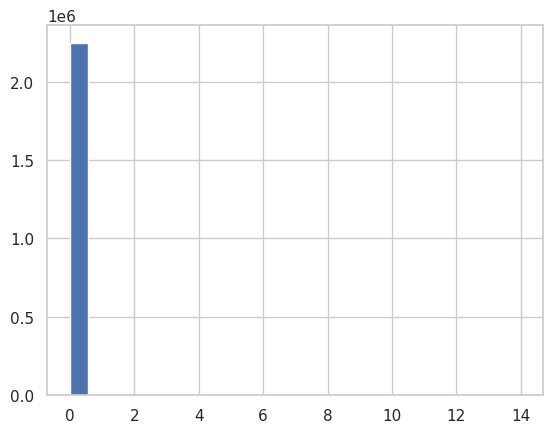

In [66]:
bins, count, plot = plt.hist(loan_data.acc_now_delinq, bins = 25)
plot

In [67]:
loan_data['acc_now_delinq'].value_counts()

acc_now_delinq
0.0     2251886
1.0        8293
2.0         421
3.0          50
4.0          11
5.0           3
6.0           2
14.0          1
7.0           1
Name: count, dtype: int64

In [68]:
# Since most of acc_now_delinq data is on zero, we will create a dummy variable to categorize it.
loan_data['acc_now_delinq:0'] = np.where(loan_data['acc_now_delinq'] == 0,1,0)

In [69]:
# We now see tot_coll_amt, which is The number of accounts on which the borrower is now delinquent.
loan_data.fillna({"tot_coll_amt": 0}, inplace = True)

<BarContainer object of 25 artists>

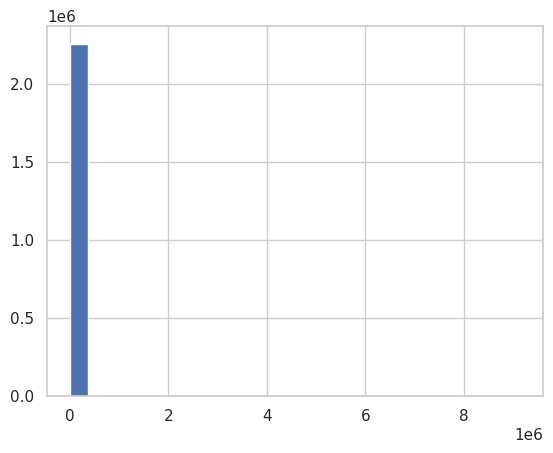

In [70]:
bins, count, plot = plt.hist(loan_data.tot_coll_amt, bins = 25)
plot

In [71]:
loan_data['tot_coll_amt'].value_counts()

tot_coll_amt
0.0        1926405
50.0          3924
100.0         3250
75.0          2489
200.0         1911
            ...   
39768.0          1
15851.0          1
9251.0           1
26632.0          1
19970.0          1
Name: count, Length: 15574, dtype: int64

In [72]:
# Since most of tot_coll_amt data is on zero, we will create a dummy variable to categorize it.
loan_data['tot_coll_amt:0'] = np.where(loan_data['tot_coll_amt'] == 0,1,0)

In [73]:
# We now see tot_cur_bal, which is the balance of all the accounts the client has
loan_data.fillna({"tot_cur_bal": loan_data.tot_cur_bal.copy().mean()}, inplace = True)

<BarContainer object of 25 artists>

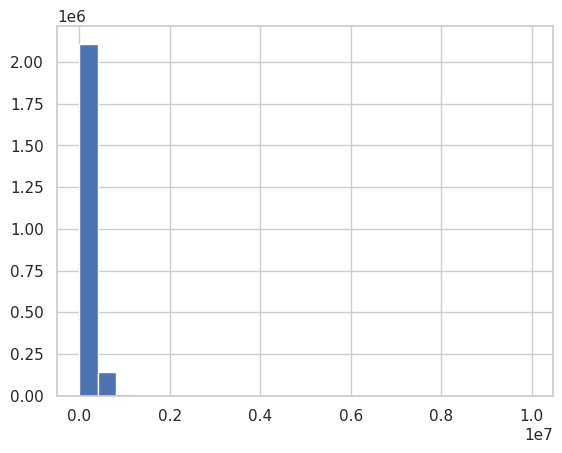

In [74]:
bins, count, plot = plt.hist(loan_data.tot_cur_bal, bins = 25)
plot

In [75]:
loan_data['tot_cur_bal_trfrm'], l_l, u_l = inter_quartile_transform(loan_data.tot_cur_bal.copy())

<BarContainer object of 25 artists>

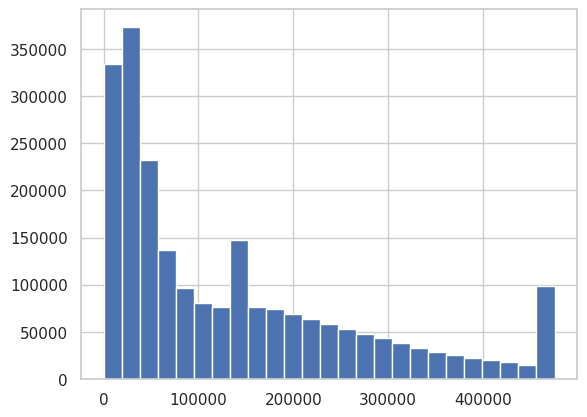

In [76]:
bins, count, plot = plt.hist(loan_data.tot_cur_bal_trfrm, bins = 25)
plot

In [77]:
# We now see tot_rev_high_lim, which is the Total revolving high credit/credit limit
loan_data.fillna({"total_rev_hi_lim": loan_data.total_rev_hi_lim.copy().mean()},
                inplace = True)

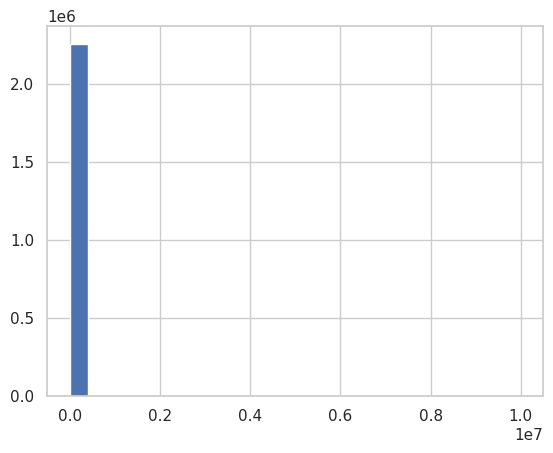

In [78]:
bins, count, plot = plt.hist(loan_data.total_rev_hi_lim, bins = 25)

In [79]:
loan_data['total_rev_hi_lim_trfrm'], l_l, u_l = inter_quartile_transform(loan_data.total_rev_hi_lim.copy())

In [80]:
# We now see avg_cur_bal, which is the Average current balance of all accounts
loan_data.fillna({"avg_cur_bal": loan_data.avg_cur_bal.copy().mean()})
loan_data["avg_cur_bal_trfrm"], l_l, u_l = inter_quartile_transform(loan_data.avg_cur_bal.copy())

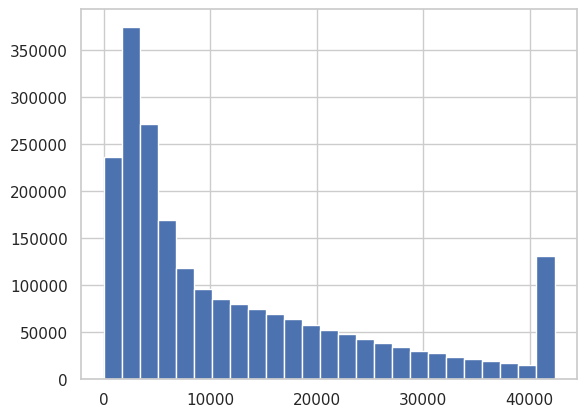

In [81]:
bins, count, plot = plt.hist(loan_data.avg_cur_bal_trfrm, bins = 25)

In [82]:
# We now see avg_cur_bal, which is the Number of mortgage accounts
loan_data.fillna({"mort_acc": 0}, inplace = True)

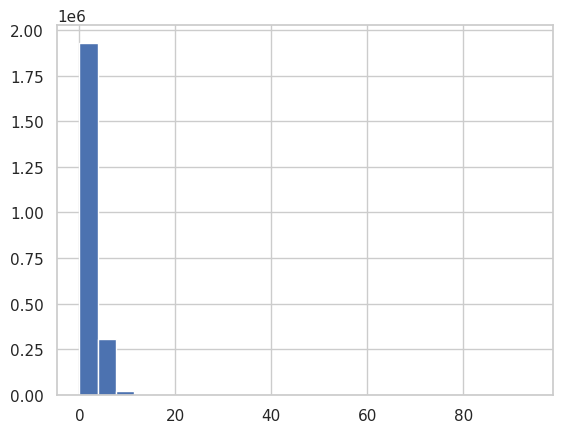

In [83]:
bins, count, plot = plt.hist(loan_data.mort_acc, bins = 25)

In [84]:
mort_acc_table = pd.crosstab(loan_data['mort_acc'],loan_data['good_bad'])
mort_acc_table['sum'] = mort_acc_table[0] + mort_acc_table[1]
mort_acc_table['prop_good'] = mort_acc_table[1]/mort_acc_table['sum']
mort_acc_table['prop_bad'] = mort_acc_table[0]/mort_acc_table['sum']
mort_acc_table

good_bad,0,1,sum,prop_good,prop_bad
mort_acc,,,,,
0.0,141973,837663,979636,0.855076,0.144924
1.0,50013,343257,393270,0.872828,0.127172
2.0,37429,288474,325903,0.885153,0.114847
3.0,25551,205515,231066,0.889421,0.110579
4.0,16350,133652,150002,0.891001,0.108999
5.0,9409,77257,86666,0.891434,0.108566
6.0,4981,41823,46804,0.893577,0.106423
7.0,2630,20789,23419,0.887698,0.112302
8.0,1234,10216,11450,0.892227,0.107773


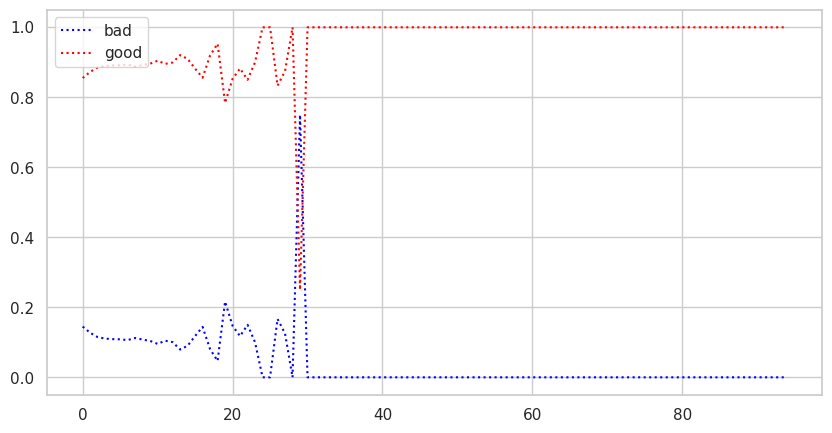

In [85]:
fig = plt.figure(figsize = (10, 5))
plt.plot(mort_acc_table.index,mort_acc_table['prop_bad'], linestyle = 'dotted',color = 'blue',label='bad')
plt.plot(mort_acc_table.index,mort_acc_table['prop_good'], linestyle = 'dotted',color = 'red',label='good')
plt.legend(loc="upper left")
plt.show()

In [86]:
# We now see mths_since_recent_bc, which is the Months since most recent bankcard account opened.
loan_data.fillna({"mths_since_recent_bc": 0}, inplace = True)

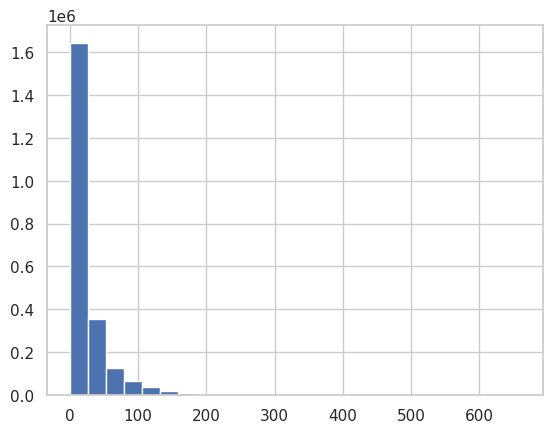

In [87]:
bins, count, plot = plt.hist(loan_data.mths_since_recent_bc, bins = 25)

In [88]:
loan_data.fillna({"num_accts_ever_120_pd": 0, # Number of accounts ever 120 or more days past due
                 "num_actv_bc_tl": 0, # Number of currently active bankcard accounts
                 "percent_bc_gt_75": loan_data.percent_bc_gt_75.copy().mean(),  # Percentage of all bankcard accounts > 75% of limit 
                 "pub_rec_bankruptcies": loan_data.pub_rec_bankruptcies.copy().mean() # Number of public record bankruptcies
                 }, 
                 inplace = True)

In [89]:
pd.crosstab(loan_data['pub_rec_bankruptcies'],loan_data['good_bad'])

good_bad,0,1
pub_rec_bankruptcies,,
0.000000,249346,1738037
0.128194,334,1031
1.000000,38552,219892
2.000000,2037,8481
3.000000,376,1755
4.000000,116,425
5.000000,38,150
6.000000,16,44
7.000000,6,17


In [90]:
#Since most of our data belongs to zero, we prefer to create a dummy variable to categorize the pubblic bankrupcies data
loan_data['pub_rec_bankruptcies:0'] = np.where(loan_data['pub_rec_bankruptcies'] == 0,1,0)
loan_data['pub_rec_bankruptcies:1-4'] = np.where((loan_data['pub_rec_bankruptcies']>=1)&(loan_data['pub_rec_bankruptcies']<=4),1,0)

In [91]:
# We now see pub_rec_bankruptcies, which is the Number of public record bankruptcies
loan_data.fillna({"tot_hi_cred_lim": loan_data.tot_hi_cred_lim.copy().mean()}, inplace = True)
# log scaling the data
loan_data["tot_hi_cred_lim_log"] = np.log(loan_data['tot_hi_cred_lim'] + 1)

In [92]:
loan_data['tot_hi_cred_lim'].value_counts()/len(loan_data['tot_hi_cred_lim'])

tot_hi_cred_lim
178242.753744    3.108639e-02
12500.000000     3.167205e-04
15000.000000     3.149512e-04
15500.000000     3.083159e-04
19000.000000     3.078736e-04
                     ...     
692952.000000    4.423471e-07
420673.000000    4.423471e-07
340661.000000    4.423471e-07
171542.000000    4.423471e-07
524379.000000    4.423471e-07
Name: count, Length: 529973, dtype: float64

In [93]:
loan_data['tot_hi_cred_lim_trfrm'], l_l, u_l = inter_quartile_transform(loan_data.tot_hi_cred_lim.copy())

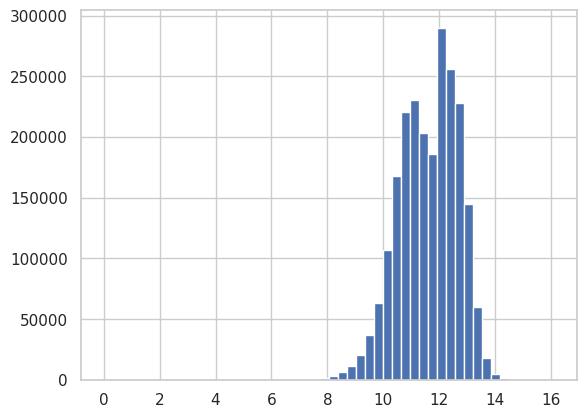

In [94]:
bins, count, plot = plt.hist(loan_data.tot_hi_cred_lim_log, bins = 50)

## Selecting the features for the model 
We have made so far just a cleaning of our data, and remove the outliers. Now with the data that we currently clened we 
will make an pre analysis in order to select the most important variables.

In [95]:
# now we make a list of the variables that we clened
cleaned_variables = [
    'loan_amnt','emp_length_num',
    'int_rate','annual_inc_trfrm','dti_trfrm',
    'delinq_2yrs','fico_range_low','fico_range_high',
    'last_fico_range_low','last_fico_range_high','inq_last_6mths',
    'open_acc','pub_rec','revol_bal_trfrm',
    'revol_util_trfrm','total_acc','collections_12_mths_ex_med',
    'acc_now_delinq','tot_coll_amt','tot_cur_bal_trfrm',
    'total_rev_hi_lim_trfrm','avg_cur_bal_trfrm',
    'mort_acc','mths_since_recent_bc','num_accts_ever_120_pd',
    'num_actv_bc_tl','percent_bc_gt_75','pub_rec_bankruptcies',
    'tot_hi_cred_lim_trfrm', 'tot_hi_cred_lim_log','good_bad'
]

In [96]:
len(cleaned_variables)

31

In [97]:
def plot_correlation_bars(data, dependent_variable, title='Correlation with Dependent Variable'):
    """
    Plots a bar plot of correlations with a dependent variable.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    dependent_variable (str): The column name of the dependent variable.
    title (str): The title of the plot (default is 'Correlation with Dependent Variable').

    Returns:
    None
    """
    correlations = data.corr()[dependent_variable].drop(dependent_variable)
    correlations_sorted = correlations.sort_values()

    plt.figure(figsize=(10, 6))
    correlations_sorted.plot(kind='bar', color=[('red' if val < 0 else 'green') for val in correlations_sorted])

    plt.title(title, fontsize=16)
    plt.xlabel('Variables', fontsize=14)
    plt.ylabel('Correlation Coefficient', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data, dependent_variable, title='Correlation Heatmap of Independent Variables'):
    """
    Plots a heatmap of the correlation matrix for the independent variables in a DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    dependent_variable (str): The column name of the dependent variable.
    title (str): The title of the heatmap (default is 'Correlation Heatmap of Independent Variables').

    Returns:
    None
    """
    # Drop the dependent variable column to keep only independent variables
    independent_data = data.drop(columns=[dependent_variable])
    
    # Compute the correlation matrix
    correlation_matrix = independent_data.corr()
    
    # Create the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')

    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

In [98]:
cleaned_variables

['loan_amnt',
 'emp_length_num',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'last_fico_range_low',
 'last_fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal_trfrm',
 'total_rev_hi_lim_trfrm',
 'avg_cur_bal_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log',
 'good_bad']

## Plotting correlations

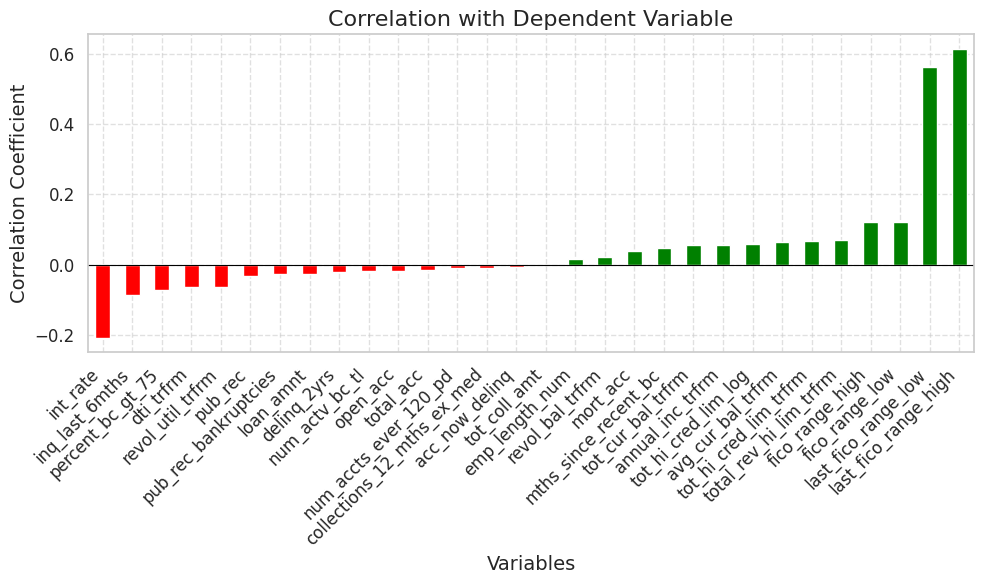

In [99]:
plot_correlation_bars(loan_data.loc[:, cleaned_variables],'good_bad')

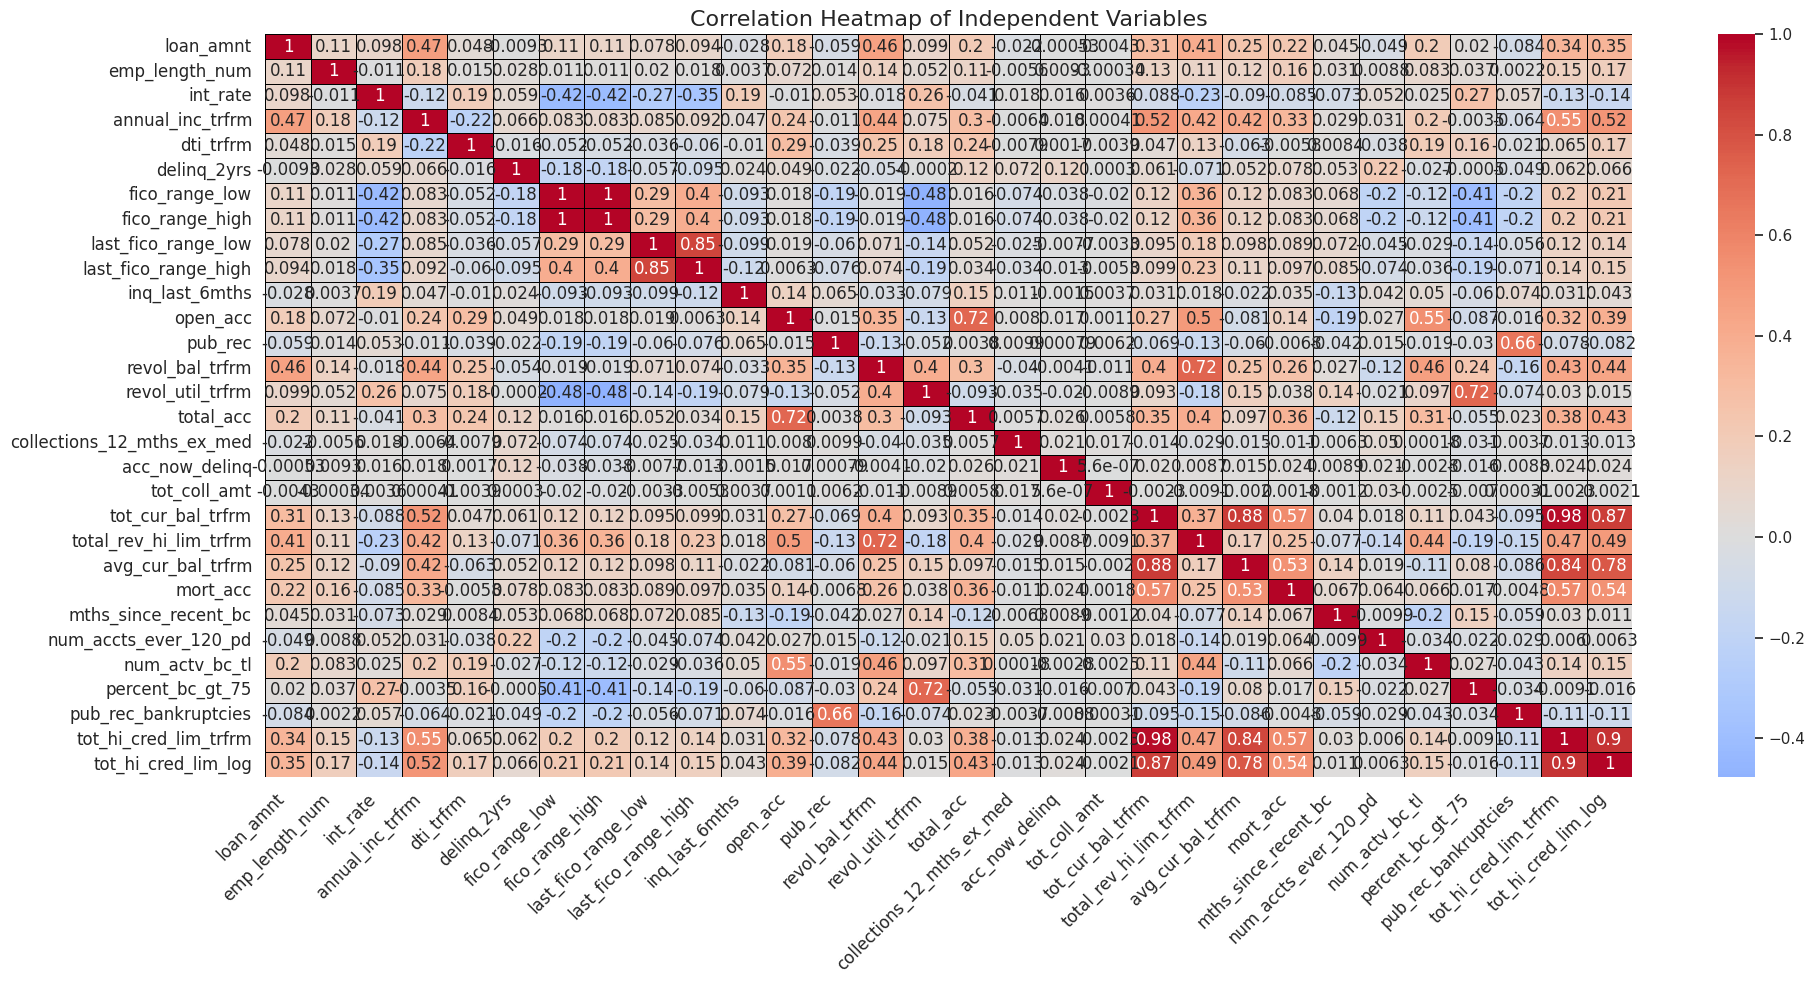

In [100]:
plot_correlation_heatmap(loan_data[cleaned_variables],'good_bad')

In [101]:
# we can see that there are variables that have high correlation with ech other. We have to remove the ones that have
# perfect correlation since one of the assupmtions from linear models is that the variables are independent of each other.
# We remove some of the variables that have 80% correlation between each other
remove_var = [
    'fico_range_low','fico_range_high','last_fico_range_low','tot_cur_bal_trfrm','avg_cur_bal_trfrm'
]

In [102]:
for i in cleaned_variables:
    if i in remove_var:
        cleaned_variables.remove(i)
        

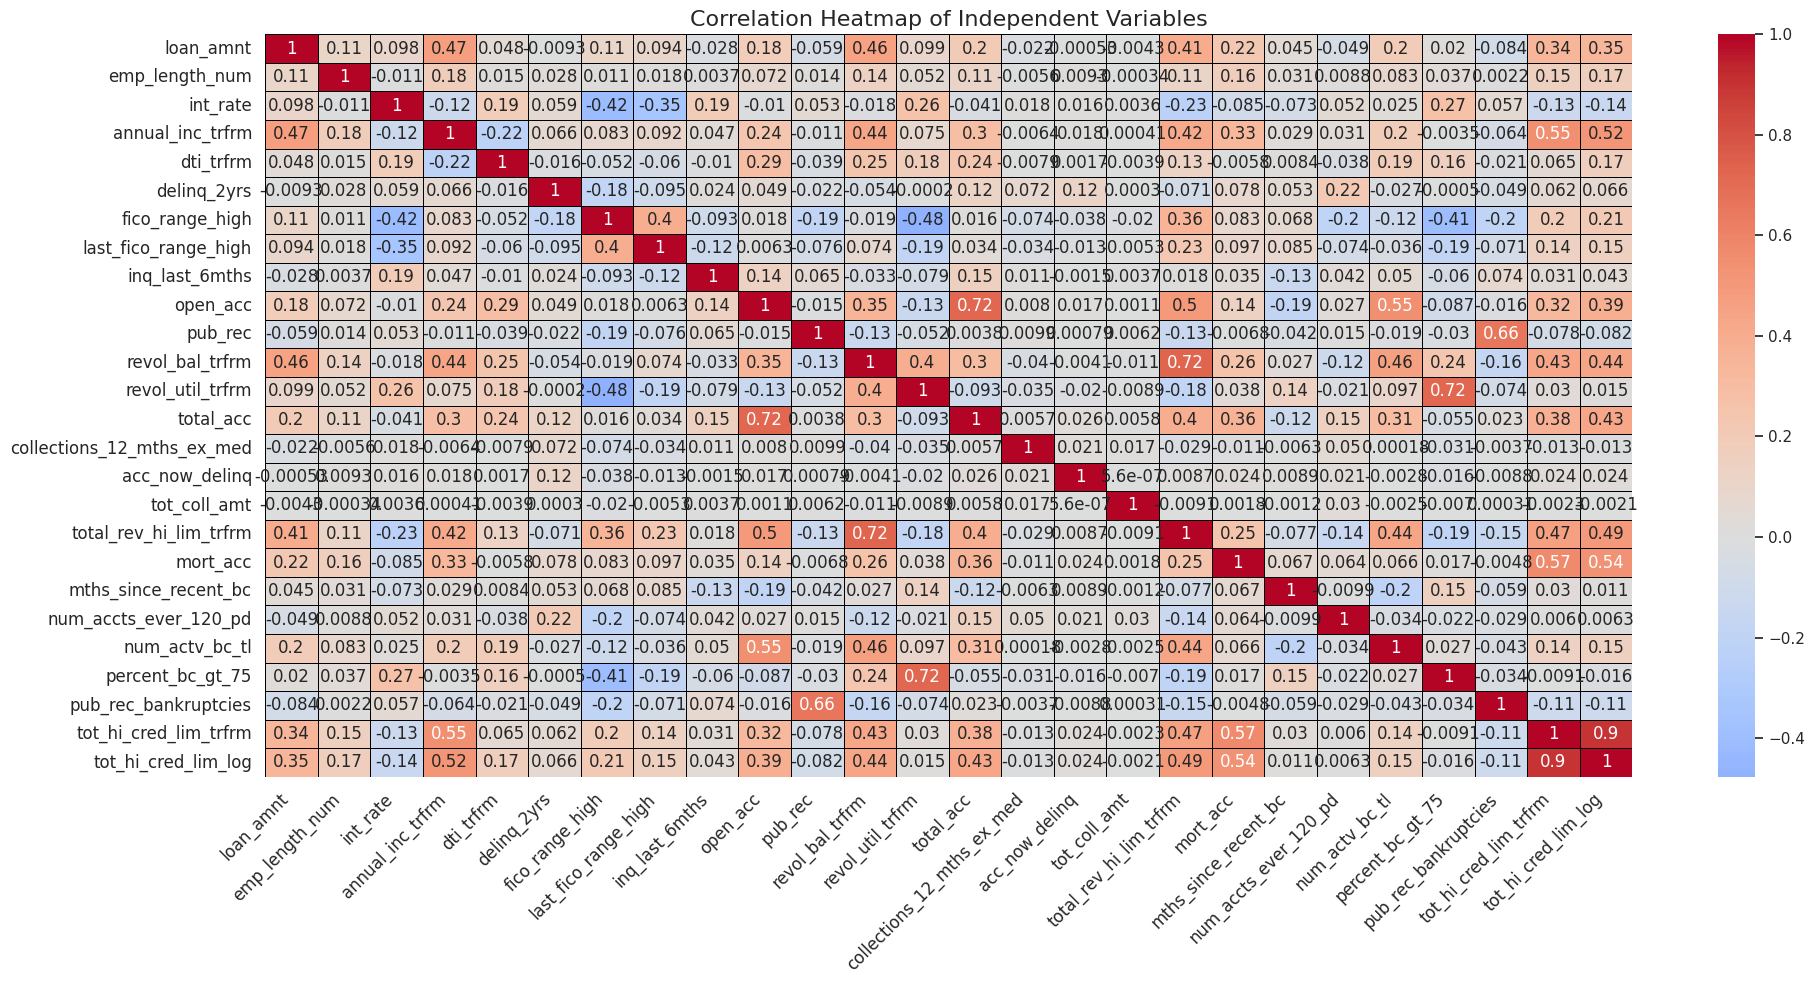

In [103]:
plot_correlation_heatmap(loan_data[cleaned_variables],'good_bad')
# As we can see on the graph we removed all the correllation values that were above 80%

## Plotting relationships between loan status and features

In [104]:
# Plotting function
def plot_var(loans, col_name, full_name, continuous, plot_style='whitegrid', color='#5975A4'):

    sns.set_style(plot_style)
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
    
    # Plot distribution
    if continuous:
        sns.histplot(loans[col_name].dropna(), kde=False, ax=ax1, color=color)
    else:
        sns.countplot(x=col_name, data=loans, order=sorted(loans[col_name].unique()), color=color, saturation=1, ax=ax1)
    
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    
    # Plot relationship with loan status
    if continuous:
        sns.boxplot(x=loans[col_name], y=loans['good_bad'].astype({"good_bad": "category"}).cat.rename_categories({0: 'bad', 1: 'good'}), ax=ax2, color=color)
        ax2.set_ylabel('')
        ax2.set_title(f'{full_name} by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['good_bad'].value_counts(normalize=True).unstack().loc[:, 0]
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color=color, saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of bad loans')
        ax2.set_title(f'Share of bad loans by {full_name}')
    
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

### Term

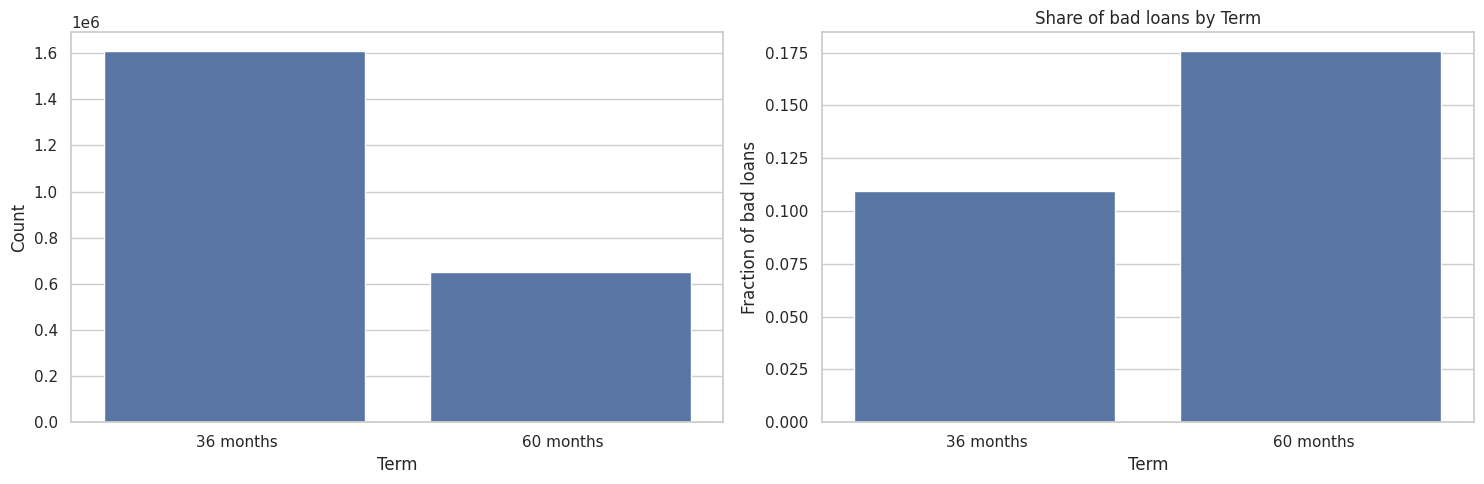

In [105]:
plot_var(loan_data, 'term_orig', 'Term', continuous=False)

### Grade

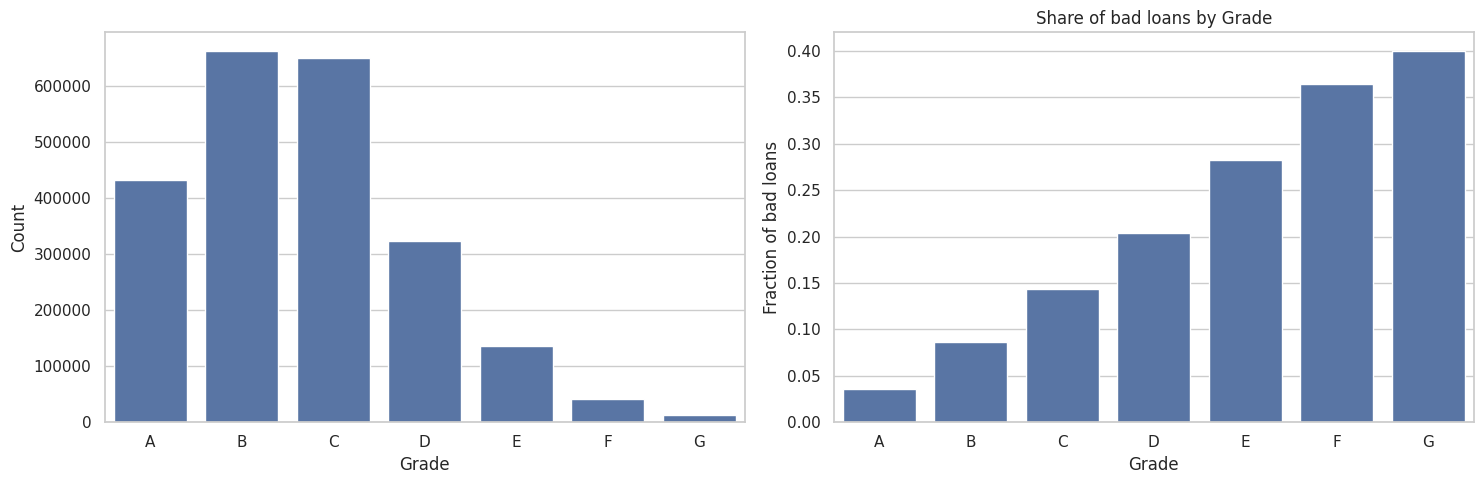

In [106]:
plot_var(loan_data, 'grade_orig', 'Grade', continuous=False)

### Loan amount

In [107]:
loan_data.groupby('good_bad')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,15651.067301,8887.866433,500.0,9000.0,14400.0,20800.0,40000.0
1,1969841.0,14957.736678,9230.702896,500.0,8000.0,12500.0,20000.0,40000.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


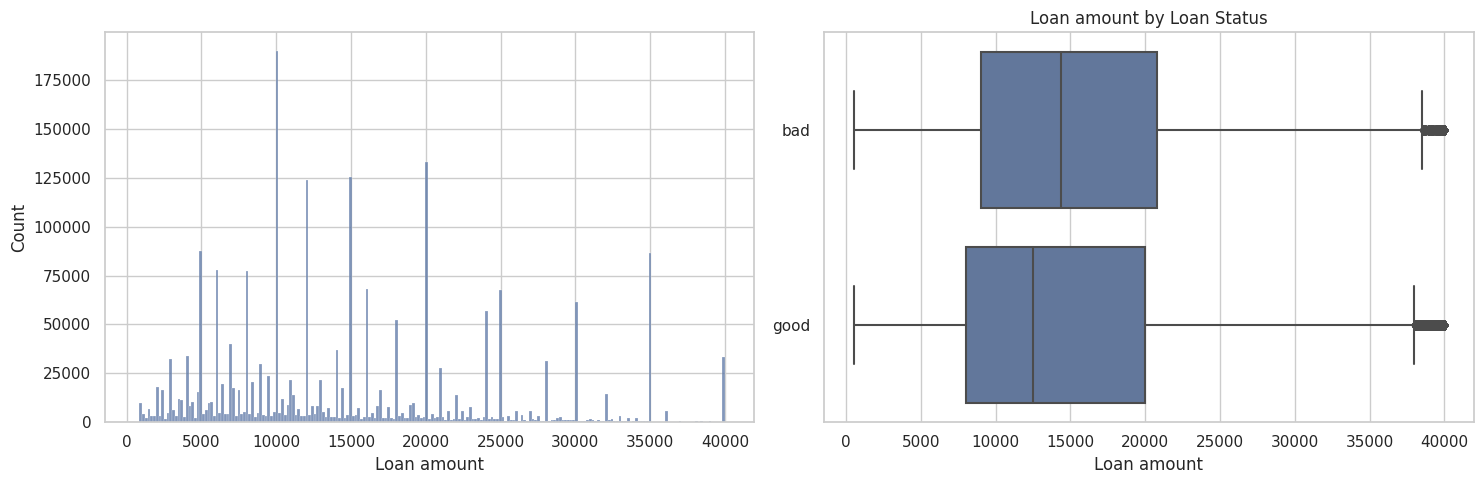

In [108]:
plot_var(loan_data, 'loan_amnt', 'Loan amount', continuous=True)

### Interest rate

In [109]:
loan_data.groupby('good_bad')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,15.702438,4.937614,5.31,12.29,15.04,18.55,30.99
1,1969841.0,12.707547,4.695057,5.31,9.17,12.12,15.31,30.99


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


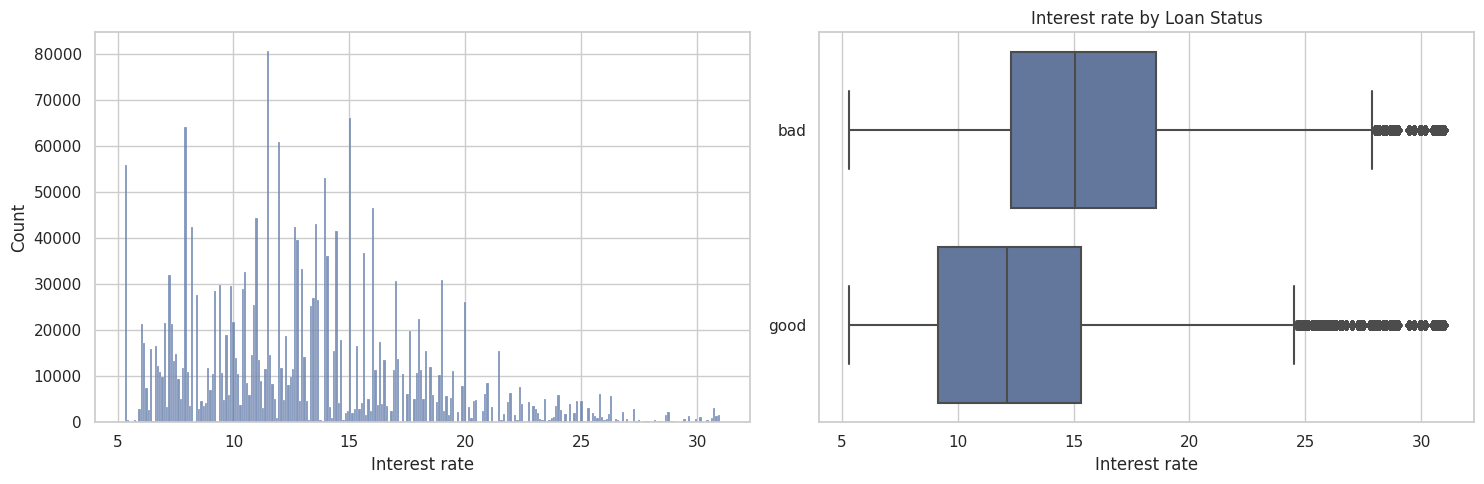

In [110]:
plot_var(loan_data, 'int_rate', 'Interest rate', continuous=True)

### Debt to income ratio

In [111]:
loan_data.groupby('good_bad')['dti_trfrm'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,19.941343,8.802271,0.0,13.44,19.68,26.26,43.35
1,1969841.0,18.268661,8.835125,-1.0,11.70,17.58,24.19,43.35


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


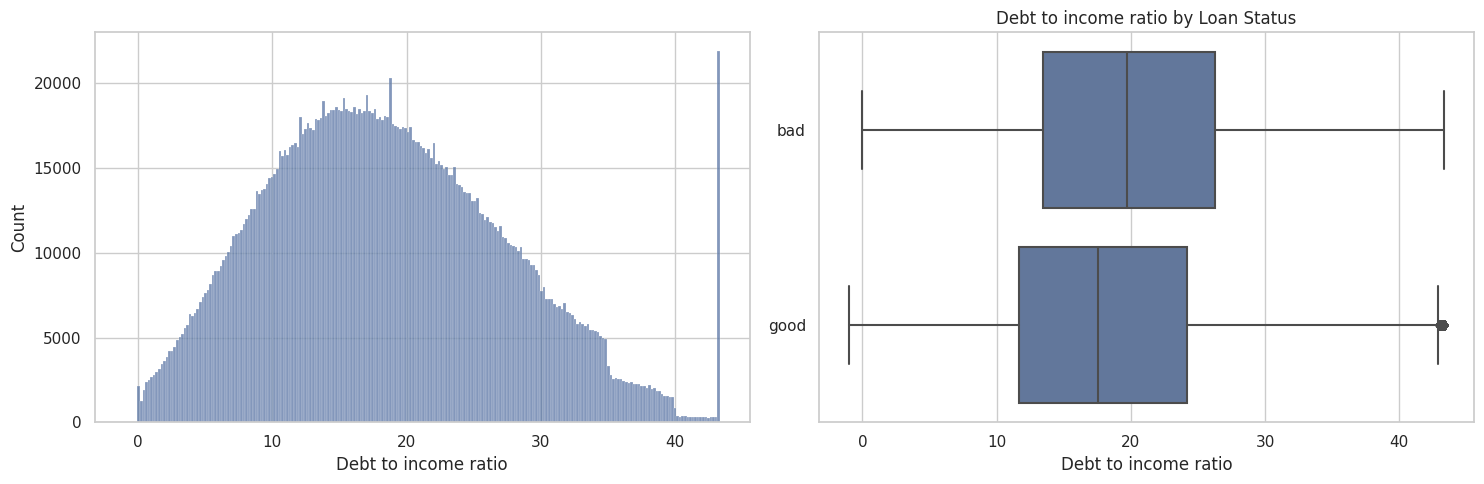

In [112]:
plot_var(loan_data, 'dti_trfrm', 'Debt to income ratio', continuous=True)

### Last Fico score low range

In [113]:
loan_data.groupby('good_bad')['last_fico_range_low'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,512.752581,186.791372,0.0,525.0,560.0,600.0,845.0
1,1969841.0,699.573598,67.257954,0.0,670.0,705.0,735.0,845.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


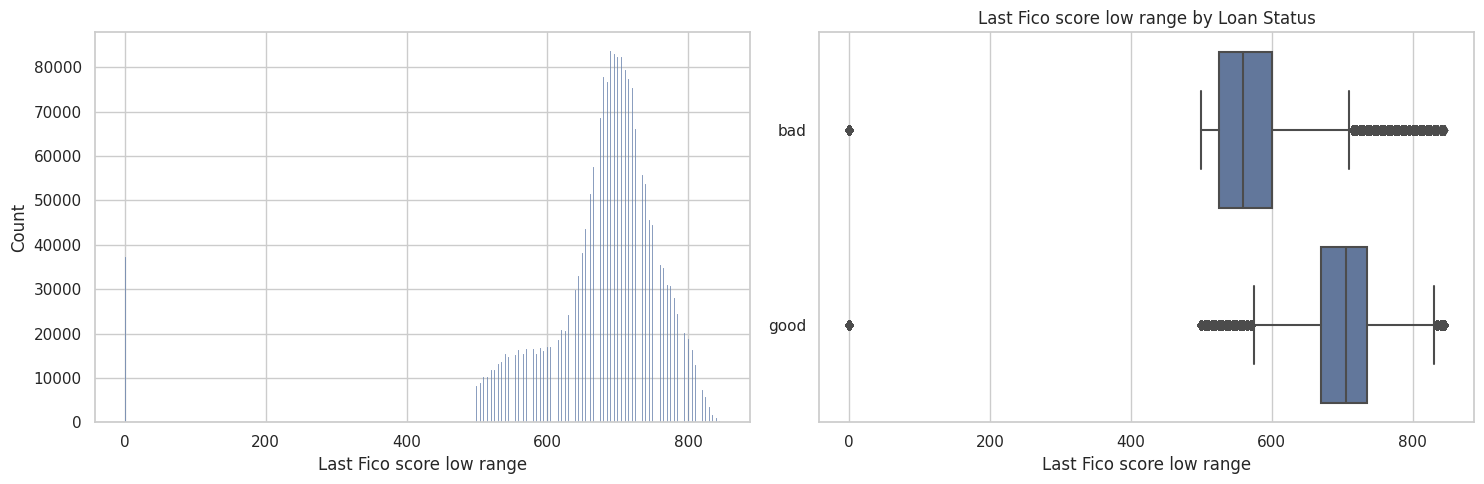

In [114]:
plot_var(loan_data, 'last_fico_range_low', 'Last Fico score low range', continuous=True)

### Annual income

In [115]:
loan_data.groupby('good_bad')['annual_inc_trfrm'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,68192.356004,34243.227100,0.0,43500.0,60000.0,85000.0,163500.0
1,1969841.0,74524.264142,37217.209124,0.0,47000.0,65400.0,95000.0,163500.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


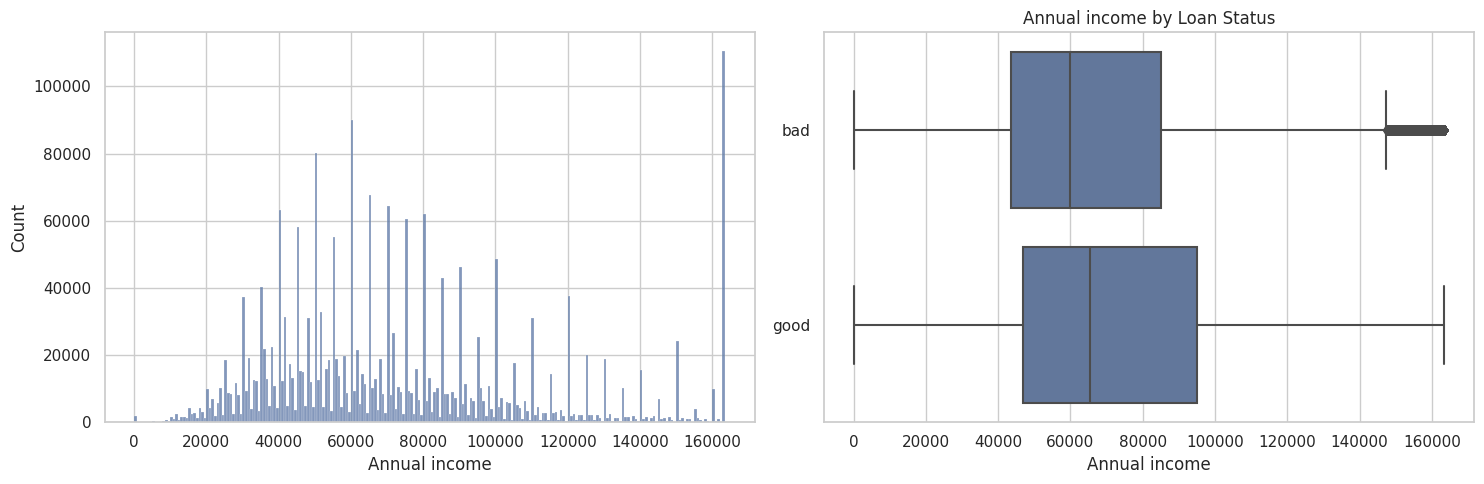

In [116]:
plot_var(loan_data, 'annual_inc_trfrm', 'Annual income', continuous=True)

### Total current balance

In [117]:
loan_data.groupby('good_bad')['tot_cur_bal_trfrm'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,117029.973347,118297.451026,0.0,28285.5,66131.0,170326.5,475419.0
1,1969841.0,138676.135515,133024.788238,0.0,30284.0,89917.0,213666.0,475419.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


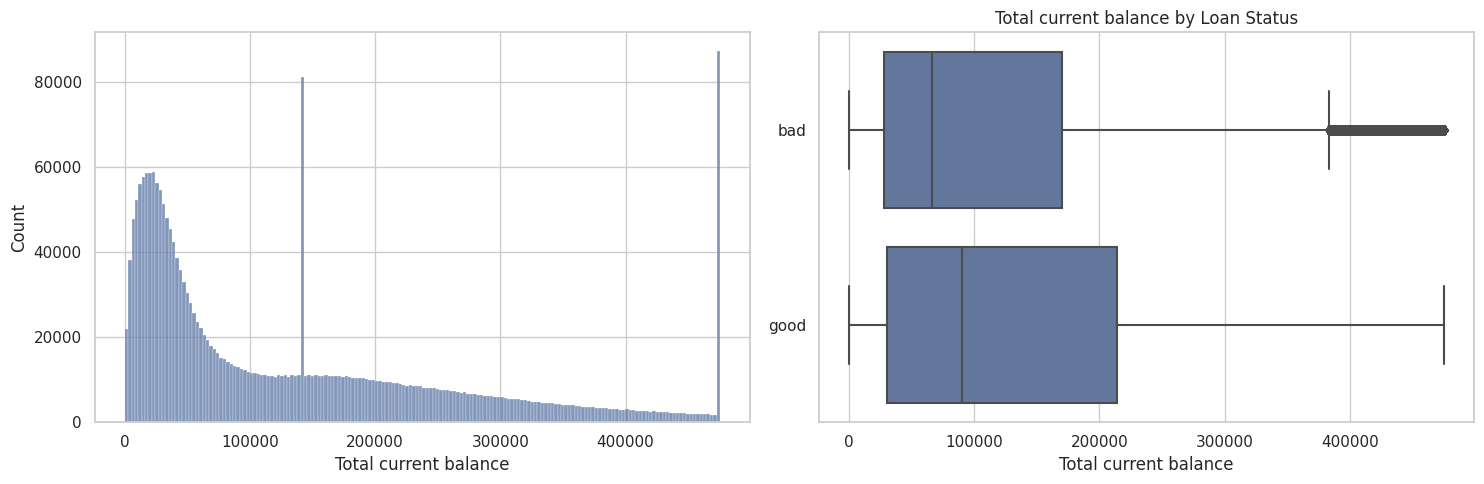

In [118]:
plot_var(loan_data, 'tot_cur_bal_trfrm', 'Total current balance', continuous=True)

### Total high credit limit

In [119]:
loan_data.groupby('good_bad')['tot_hi_cred_lim_trfrm'].describe()

,count,mean,std,min,25%,50%,75%,max
good_bad,,,,,,,,
0,290827.0,145237.445331,131716.461423,0.0,46123.5,94014.0,203534.5,552495.5
1,1969841.0,174715.653113,149452.199718,0.0,53100.0,126656.0,259066.0,552495.5


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


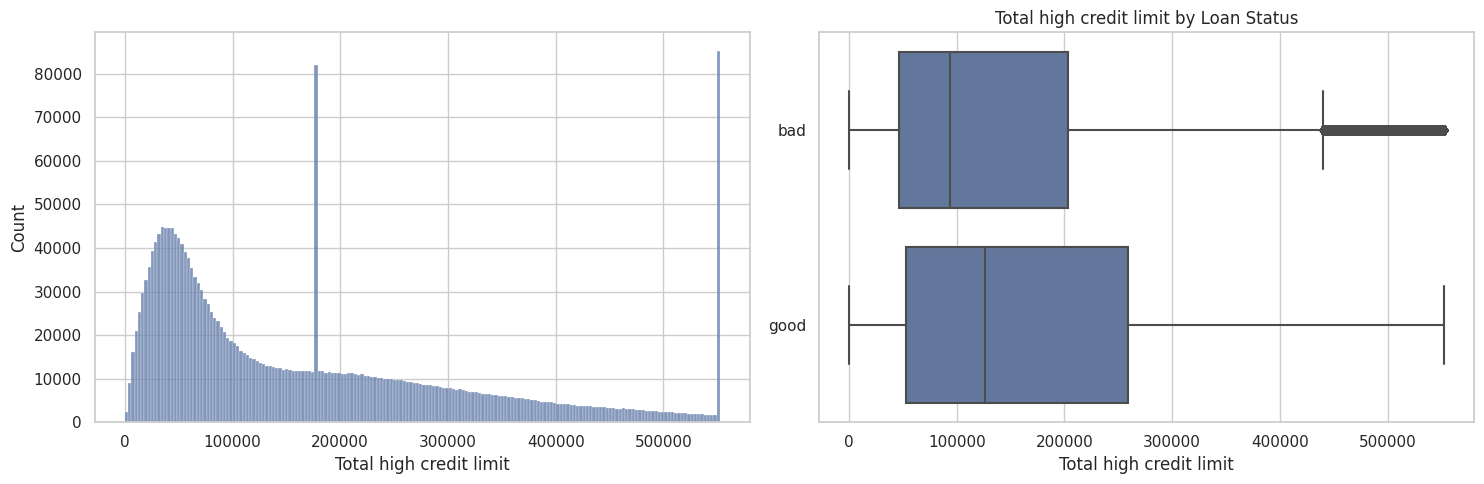

In [120]:
plot_var(loan_data, 'tot_hi_cred_lim_trfrm', 'Total high credit limit', continuous=True)

## Summarizing the cleaned variables

In [121]:
## now we want also to get the dummy variables we already created, but instead of looking to every sigle one of them
## we can use this function
element_with_colon = list(filter(lambda x: ':' in x, loan_data.columns))

In [122]:
cleaned_variables

['loan_amnt',
 'emp_length_num',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log',
 'good_bad']

In [123]:
# Loop through each element in list2
for element in element_with_colon:
    # Check if element is not in list1
    if element not in cleaned_variables:
        # Append the element to list1
        cleaned_variables.append(element)

In [124]:
cleaned_variables

['loan_amnt',
 'emp_length_num',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log',
 'good_bad',
 'home_ownership:MORTGAGE',
 'home_ownership:NONE',
 'home_ownership:OTHER',
 'home_ownership:OWN',
 'home_ownership:RENT',
 'purpose_trfrm:debt_consolidation',
 'purpose_trfrm:home_improvement',
 'purpose_trfrm:other',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'grade:G',
 'term: 60 months',
 'inq_last_6mths:0',
 'inq_last_6mths:1-8',
 'pub_rec:0',
 'pub_rec:1-9',
 'collections_12_mths_ex_med:0',
 'collections_12_mths_ex_med:1-4',
 'acc_now_delinq:0'

In [125]:
# Now we finally insert the id in order that if we split the data and separete the target variable we have a reference 
cleaned_variables.insert(0, 'id')

In [126]:
cleaned_variables

['id',
 'loan_amnt',
 'emp_length_num',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log',
 'good_bad',
 'home_ownership:MORTGAGE',
 'home_ownership:NONE',
 'home_ownership:OTHER',
 'home_ownership:OWN',
 'home_ownership:RENT',
 'purpose_trfrm:debt_consolidation',
 'purpose_trfrm:home_improvement',
 'purpose_trfrm:other',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'grade:G',
 'term: 60 months',
 'inq_last_6mths:0',
 'inq_last_6mths:1-8',
 'pub_rec:0',
 'pub_rec:1-9',
 'collections_12_mths_ex_med:0',
 'collections_12_mths_ex_med:1-4',
 'acc_now_de

In [127]:
lista_rep = []
for i in list(filter(lambda x: ':' in x, cleaned_variables)):
    name = i.split(':')[0]
    lista_rep.append(name)

In [128]:
lista_rep

['home_ownership',
 'home_ownership',
 'home_ownership',
 'home_ownership',
 'home_ownership',
 'purpose_trfrm',
 'purpose_trfrm',
 'purpose_trfrm',
 'grade',
 'grade',
 'grade',
 'grade',
 'grade',
 'grade',
 'term',
 'inq_last_6mths',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec',
 'collections_12_mths_ex_med',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'pub_rec_bankruptcies',
 'pub_rec_bankruptcies']

In [129]:
lista_rep = list(dict.fromkeys(lista_rep))
for element in lista_rep:
    # Check if element is not in list1
    if element in cleaned_variables:
        # Append the element to list1
        cleaned_variables.remove(element)
cleaned_variables

['id',
 'loan_amnt',
 'emp_length_num',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'open_acc',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log',
 'good_bad',
 'home_ownership:MORTGAGE',
 'home_ownership:NONE',
 'home_ownership:OTHER',
 'home_ownership:OWN',
 'home_ownership:RENT',
 'purpose_trfrm:debt_consolidation',
 'purpose_trfrm:home_improvement',
 'purpose_trfrm:other',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'grade:G',
 'term: 60 months',
 'inq_last_6mths:0',
 'inq_last_6mths:1-8',
 'pub_rec:0',
 'pub_rec:1-9',
 'collections_12_mths_ex_med:0',
 'collections_12_mths_ex_med:1-4',
 'acc_now_delinq:0',
 'tot_coll_amt:0',
 'pub_rec_bankruptcies:0',
 'pub_rec_bankruptcies:1-4']

### Splitting data

In [130]:
len(cleaned_variables)

47

## Train-test split
To benchmark our models, we will devide the data into training and testing parts.

Later we will train the best model on the whole dataset.

In [131]:
loan_data_inputs_train, loan_data_inputs_test,loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data[cleaned_variables].drop('good_bad', axis = 1), loan_data[cleaned_variables]['good_bad'])

In [132]:
#loan_data_inputs_train.to_csv('/kaggle/working/loan_data_inputs_train.csv')
#loan_data_targets_train.to_csv('/kaggle/working/loan_data_targets_train.csv')
#loan_data_inputs_test.to_csv('/kaggle/working/loan_data_inputs_test.csv')
#loan_data_targets_test.to_csv('/kaggle/working/loan_data_targets_test.csv')

In [133]:
# loan_data.to_csv('/kaggle/working/Proprocessed_loan_data.csv')

# Modelling

We want to remove the 'id' column for our analysis.

In [135]:
### remove id
inputs_train = loan_data_inputs_train.drop('id',axis = 1)
inputs_test = loan_data_inputs_test.drop('id',axis = 1)

### Evaluate a binary classification model on the test set and return various metrics.

    Parameters:
    - model: The binary classification model to be evaluated.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    A dictionary containing the following metrics:
    - Accuracy
    - Sensitivity (Recall)
    - Specificity
    - Precision
    - Negative predictive value
    - F1 Score
    - AUC (Area Under the Curve)
    - False discovery rate

In [136]:
def evaluate_model(model, X_test, y_test,tr):

    # Predict the probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    # Predict the binary labels
    y_pred = np.where(y_prob > tr, 1, 0)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    fdr = fp/(fp+tp)
    npv = tn/(fn+tn)
    # Create a dictionary to store the metrics
    metrics = {
        "Accuracy": accuracy,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "Negative predictive value": npv,
        "F1 Score": f1,
        "AUC": auc,
        "False discovery rate": fdr
    }
    
    return metrics

## XGBoost Classifier

In [137]:
# Train and evaluate an XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_param = xgb_model.get_xgb_params()
xgb_param['num_class'] = 3

xgb_model.fit(inputs_train.to_numpy(), loan_data_targets_train.to_numpy())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [138]:
# Evaluate the model
xgb_metrics = evaluate_model(xgb_model,inputs_test.to_numpy(), loan_data_targets_test.to_numpy(),0.85)
xgb_metrics_df = pd.DataFrame.from_dict(xgb_metrics,orient = 'index').rename(columns = {0:'xgb'})
xgb_metrics_df

,xgb
Accuracy,0.896514
Sensitivity (Recall),0.896415
Specificity,0.897178
Precision,0.983317
Negative predictive value,0.561623
F1 Score,0.937857
AUC,0.953114
False discovery rate,0.016683


## Random Forest

In [139]:
model = RandomForestClassifier(random_state=42,max_depth=5) 
model.fit(inputs_train, loan_data_targets_train) # fit the model

RandomForestClassifier(max_depth=5, random_state=42)

In [140]:
# Evaluate the model
metrics = evaluate_model(model, inputs_test, loan_data_targets_test,0.85)
random_forest_metrics = pd.DataFrame.from_dict(metrics,orient = 'index').rename(columns = {0:'Random_Forest'})
random_forest_metrics

,Random_Forest
Accuracy,0.890195
Sensitivity (Recall),0.897114
Specificity,0.843419
Precision,0.974833
Negative predictive value,0.548034
F1 Score,0.934360
AUC,0.919569
False discovery rate,0.025167


## Logistic Regression

In [141]:
reg = LogisticRegression(max_iter=1000)
reg.fit(inputs_train, loan_data_targets_train) 

LogisticRegression(max_iter=1000)

In [142]:
# Evaluate the model
metrics = evaluate_model(reg, inputs_test, loan_data_targets_test,0.85)
logit_metrics = pd.DataFrame.from_dict(metrics,orient = 'index').rename(columns = {0:'Logit'})
logit_metrics

,Logit
Accuracy,0.897720
Sensitivity (Recall),0.903476
Specificity,0.858812
Precision,0.977407
Negative predictive value,0.568232
F1 Score,0.938988
AUC,0.941577
False discovery rate,0.022593


## Naive Bayes

In [143]:
nb_model = GaussianNB()
nb_model.fit(inputs_train.to_numpy(), loan_data_targets_train.to_numpy())

GaussianNB()

In [144]:
# Evaluate the model
nb_metrics = evaluate_model(nb_model,inputs_test.to_numpy(), loan_data_targets_test.to_numpy(),0.85)
nb_df = pd.DataFrame.from_dict(nb_metrics,orient = 'index').rename(columns = {0:'Naive Bayes'})
nb_df

,Naive Bayes
Accuracy,0.860431
Sensitivity (Recall),0.861413
Specificity,0.853786
Precision,0.975508
Negative predictive value,0.476785
F1 Score,0.914917
AUC,0.919184
False discovery rate,0.024492


# Compare results of all models

In [145]:
table_of_outputs = pd.concat([logit_metrics,random_forest_metrics,xgb_metrics_df,nb_df],axis = 1)
table_of_outputs

,Logit,Random_Forest,xgb,Naive Bayes
Accuracy,0.897720,0.890195,0.896514,0.860431
Sensitivity (Recall),0.903476,0.897114,0.896415,0.861413
Specificity,0.858812,0.843419,0.897178,0.853786
Precision,0.977407,0.974833,0.983317,0.975508
Negative predictive value,0.568232,0.548034,0.561623,0.476785
F1 Score,0.938988,0.934360,0.937857,0.914917
AUC,0.941577,0.919569,0.953114,0.919184
False discovery rate,0.022593,0.025167,0.016683,0.024492


## ROC Curve of XGBoost

ROC-AUC-Score of the XGBoost model:  0.9531142972585839


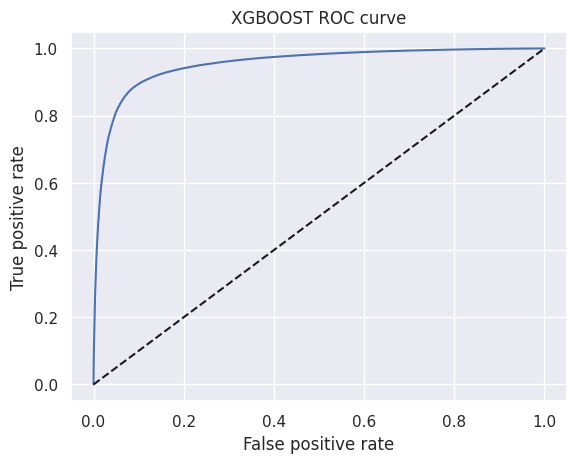

In [146]:
y_hat_test_proba = xgb_model.predict_proba(inputs_test)
y_hat_test_proba = y_hat_test_proba[: ][: , 1]

loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

df_actual_predicted_probs = pd.concat([loan_data_targets_test, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs = pd.concat([loan_data_targets_test, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

tr = 0.85
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)


fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBOOST ROC curve')

AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC) from a set of actual values and their predicted probabilities.
print("ROC-AUC-Score of the XGBoost model: ",AUROC)

We can also take a look at the confusion matrix:

In [147]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,65337,7488
1,50999,441343


In [148]:
print(classification_report(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test']))

              precision    recall  f1-score   support

           0       0.56      0.90      0.69     72825
           1       0.98      0.90      0.94    492342

    accuracy                           0.90    565167
   macro avg       0.77      0.90      0.81    565167
weighted avg       0.93      0.90      0.91    565167



# Modeling Loss Given Default

Now we need to model the second component of expected loss which is the loss given default
the loss given default can be expressed as
$(1- RR)$.

Where $RR$ is the recovery rate. This is the rate of recovery of loans that are expected to be defaulted with respect to the original founded amaount

We create the column 'recovery rate', which is the share of recoveries out of the total funded amount.

In [149]:
loan_data['recovery_rate'] = loan_data['recoveries']/loan_data['funded_amnt']
loan_data['recovery_rate'].isna().sum()

0

Because the beta regression works on the open interval (0,1), we replace 0 and 1 from our data with 0.0001 and 0.9999, respectively.

In [151]:
loan_data['recovery_rate'] = np.where(loan_data['recovery_rate'] >=1,0.9999,loan_data['recovery_rate'])
loan_data['recovery_rate'] = np.where(loan_data['recovery_rate'] == 0,0.0001,loan_data['recovery_rate'])

In [152]:
list_variables = inputs_train.columns.to_list()
list_variables.append('recovery_rate')


We train the model only with observations where non-zero recoveries exist.

In [153]:
loan_data_rr = loan_data[(loan_data['recoveries']>0)]
loan_data_rr =loan_data_rr.loc[:,list_variables]
loan_data_rr['recovery_rate'].isna().sum()

0

Of course, we will split our data into train and test data.

In [154]:
loan_data_inputs_train_rr, loan_data_inputs_test_rr,loan_data_targets_train_rr, loan_data_targets_test_rr = train_test_split(loan_data_rr.drop('recovery_rate', axis = 1), loan_data_rr['recovery_rate'], random_state=42)

These are the features that we will use for our beta regression.

In [155]:
loan_data_inputs_train_rr.head()

,loan_amnt,emp_length_num,int_rate,annual_inc_trfrm,dti_trfrm,delinq_2yrs,fico_range_high,last_fico_range_high,open_acc,revol_bal_trfrm,revol_util_trfrm,total_acc,total_rev_hi_lim_trfrm,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,percent_bc_gt_75,tot_hi_cred_lim_trfrm,tot_hi_cred_lim_log,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose_trfrm:debt_consolidation,purpose_trfrm:home_improvement,purpose_trfrm:other,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,term: 60 months,inq_last_6mths:0,inq_last_6mths:1-8,pub_rec:0,pub_rec:1-9,collections_12_mths_ex_med:0,collections_12_mths_ex_med:1-4,acc_now_delinq:0,tot_coll_amt:0,pub_rec_bankruptcies:0,pub_rec_bankruptcies:1-4
1909330,9800.0,2,6.03,40800.0,3.79,0.0,794.0,514.0,6.0,3203.0,7.1,11.0,45176.0,0.0,15.0,0.0,3.0,0.0,50676.0,10.833227,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0
742559,2000.0,10,15.31,43000.0,20.15,0.0,744.0,504.0,4.0,7947.0,59.8,10.0,13300.0,0.0,24.0,0.0,3.0,66.7,42009.0,10.645663,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0
1903499,4000.0,6,10.16,120000.0,13.93,1.0,709.0,549.0,11.0,12828.0,35.9,21.0,35700.0,1.0,28.0,1.0,5.0,40.0,338495.0,12.732268,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0
719200,14000.0,1,18.25,35000.0,29.73,0.0,679.0,614.0,18.0,7751.0,46.7,42.0,16600.0,1.0,10.0,2.0,4.0,50.0,210725.0,12.258314,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,0,1
61417,20000.0,1,17.86,45000.0,38.29,0.0,699.0,599.0,14.0,23866.0,78.5,41.0,30400.0,0.0,2.0,0.0,6.0,33.3,144283.0,11.879539,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,1,1,0


In [156]:
list_numeric = loan_data_inputs_train_rr.columns[loan_data_inputs_train_rr.dtypes == 'float64'].to_list()

In [162]:
list_numeric

['loan_amnt',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'open_acc',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log']

# Beta regression

We procede to regress our $RR$ variable with respect to our dependent variables and we use the
beta regression as our model. We use the beta regression since we need a model that can regress our dependent variable on the space (0,1) and since the linear regression is not restricted on that condition we need a model that can restrain the output of the dependent variable.

In [157]:
loan_data_inputs_train_rr.loc[:,loan_data_inputs_train_rr.dtypes == 'float64'].head()

,loan_amnt,int_rate,annual_inc_trfrm,dti_trfrm,delinq_2yrs,fico_range_high,last_fico_range_high,open_acc,revol_bal_trfrm,revol_util_trfrm,total_acc,total_rev_hi_lim_trfrm,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,percent_bc_gt_75,tot_hi_cred_lim_trfrm,tot_hi_cred_lim_log
1909330,9800.0,6.03,40800.0,3.79,0.0,794.0,514.0,6.0,3203.0,7.1,11.0,45176.0,0.0,15.0,0.0,3.0,0.0,50676.0,10.833227
742559,2000.0,15.31,43000.0,20.15,0.0,744.0,504.0,4.0,7947.0,59.8,10.0,13300.0,0.0,24.0,0.0,3.0,66.7,42009.0,10.645663
1903499,4000.0,10.16,120000.0,13.93,1.0,709.0,549.0,11.0,12828.0,35.9,21.0,35700.0,1.0,28.0,1.0,5.0,40.0,338495.0,12.732268
719200,14000.0,18.25,35000.0,29.73,0.0,679.0,614.0,18.0,7751.0,46.7,42.0,16600.0,1.0,10.0,2.0,4.0,50.0,210725.0,12.258314
61417,20000.0,17.86,45000.0,38.29,0.0,699.0,599.0,14.0,23866.0,78.5,41.0,30400.0,0.0,2.0,0.0,6.0,33.3,144283.0,11.879539


In [158]:
# fit the model
model_sm = BetaModel(loan_data_targets_train_rr,loan_data_inputs_train_rr[list_numeric]).fit() 

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:2750: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "


In [159]:
# create predictions
mu_sm = model_sm.predict(loan_data_inputs_test_rr[list_numeric]) 

In [160]:
print(mu_sm.shape)
print(loan_data_targets_test_rr.shape)

(46358,)
(46358,)


## Results of the beta regression

In [161]:
mse_sm = mean_squared_error(loan_data_targets_test_rr, mu_sm)
mae_sm = mean_absolute_error(loan_data_targets_test_rr,mu_sm)
print("\nStatsmodels Beta Regression Results:")
print(model_sm.summary())


Statsmodels Beta Regression Results:
                              BetaModel Results                               
Dep. Variable:          recovery_rate   Log-Likelihood:             1.6706e+05
Model:                      BetaModel   AIC:                        -3.341e+05
Method:            Maximum Likelihood   BIC:                        -3.339e+05
Date:                Sun, 14 Jul 2024                                         
Time:                        19:22:38                                         
No. Observations:              139074                                         
Df Residuals:                  139054                                         
Df Model:                          18                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
loan_amnt               2.165e-06   3.33e-07      6.492      0.000   

In this case the metric of interest is the mean absolute square, since the squared error for values between 0 and 1 make the error smaller.

In [163]:
print("Mean Squared Error:", mse_sm)
print("Mean Absolute Error:", mae_sm)

Mean Squared Error: 0.009694870900588876
Mean Absolute Error: 0.060549105165627226


## Compare predictions with actual values

In [169]:
mu_sm.describe() #predictions

count    46358.000000
mean         0.114279
std          0.018012
min          0.053142
25%          0.102677
50%          0.113580
75%          0.125062
max          0.240999
dtype: float64

In [170]:
loan_data_targets_test_rr.describe() #actual values

count    4.635800e+04
mean     1.097072e-01
std      9.759625e-02
min      5.000000e-07
25%      5.714360e-02
50%      9.359274e-02
75%      1.296216e-01
max      9.999000e-01
Name: recovery_rate, dtype: float64

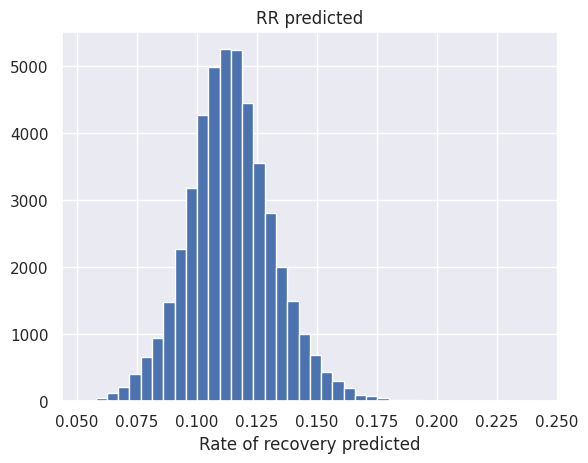

In [171]:
# As we can see the mean of recovery is 11% which is not far away from the 10% of the testing data
# Also we can see that 
plt.hist(mu_sm, bins=40) # distribution of the predictions
plt.title("RR predicted")
plt.xlabel('Rate of recovery predicted')
plt.show()

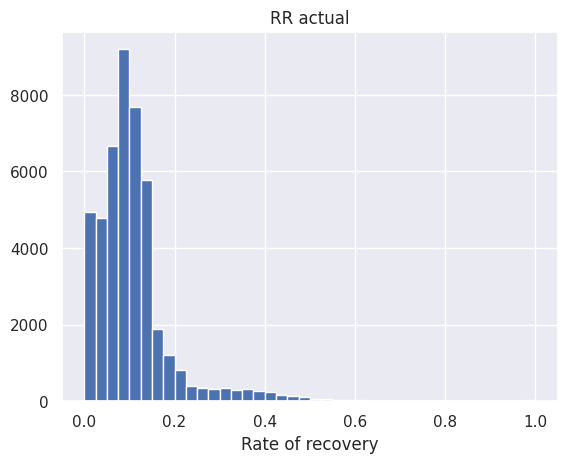

In [172]:
plt.hist(loan_data_targets_test_rr, bins=40) # distribution of actual recovery rate
plt.title("RR actual")
plt.xlabel('Rate of recovery')
plt.show()

We create now the recovery rate variable

In [175]:
list_beta = loan_data_inputs_test_rr.loc[:,list_numeric].columns.to_list()
list_beta

['loan_amnt',
 'int_rate',
 'annual_inc_trfrm',
 'dti_trfrm',
 'delinq_2yrs',
 'fico_range_high',
 'last_fico_range_high',
 'open_acc',
 'revol_bal_trfrm',
 'revol_util_trfrm',
 'total_acc',
 'total_rev_hi_lim_trfrm',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'percent_bc_gt_75',
 'tot_hi_cred_lim_trfrm',
 'tot_hi_cred_lim_log']

In [176]:
list_variables.remove('recovery_rate')
loan_data['PD'] = 1-(xgb_model.predict_proba(loan_data[list_variables])[:, 1]) #probability of default
loan_data['LGD'] = 1-(model_sm.predict(loan_data.loc[:,list_numeric])) # loss igven default
loan_data['EAD'] = loan_data['loan_amnt'] - loan_data['total_rec_prncp'] # exposure at default

### What are the losses? 

### Expected losses

In [177]:
loan_data['EL'] = loan_data['PD']*loan_data['LGD']*loan_data['EAD'] # expected loss
EL = loan_data['EL'].sum().round(2) # sum of all expected losses

print("The expected loss is: ",'${:,.2f}'.format(EL))

The expected loss is:  $2,143,793,251.01


### Relative expected loss:

In [178]:
ELP =(loan_data['EL'].sum()/loan_data['funded_amnt'].sum()).round(2)
print("The expected loss as a percentage of the funded amount is: ",str(ELP))

The expected loss as a percentage of the funded amount is:  0.06


We can expect a relative loss of 6 percent. Which is sensible for a portfolio that the main purpose is debt cosolidation. That means clients that are already in debt, and the bank wants to close prior debt with a new type of debt.